In [33]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
from jaxns.framework.model import Model
from jaxns.framework.prior import Prior
import jax
import tensorflow_probability.substrates.jax as tfp
import jax.numpy as jnp
tfpd = tfp.distributions
from jaxns import NestedSampler, TerminationCondition, resample
from jaxns.framework.model import Model
from jaxns.framework.prior import Prior
from jax import random,vmap, grad
from jax.lax import while_loop

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

### EI test

In [34]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 32
ndim = 2
train_x_unit = qmc.Sobol(ndim, scramble=True).random(ninit)

pi = np.pi
def loglike(theta):
    return jnp.power(2. + jnp.cos(0.5 *pi* theta[:,0])*jnp.sin(0.5*pi*theta[:,1]), 5)


param_bounds = np.array([[0,10],[0,10]]).T

print(param_bounds[1],param_bounds[0])

# print(param_bounds[0,1])

def input_standardize(x):
    """
    Project from original domain to unit hypercube, X is N x d shaped, param_bounds are 2 x d
    """
    x =  (x - param_bounds[0])/(param_bounds[1] - param_bounds[0])
    return x

def input_unstandardize(x):
    """
    Project from unit hypercube to original domain, X is N x d shaped, param_bounds are 2 x d
    """
    x = x * (param_bounds[1] - param_bounds[0]) + param_bounds[0]
    return x

train_x = input_unstandardize(train_x_unit)

# print(train_x)


train_y = loglike(train_x).reshape(-1,1)
# print(train_x,train_x_unit)
print(train_x.shape,train_y.shape)

# train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x_unit,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)


[10 10] [0 0]
(32, 2) (32, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:03<00:00, 341.24it/s, 7 steps of size 2.96e-01. acc. prob=0.91]


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]    170.35    469.55      3.16      0.04    427.70     39.30      0.97
_kernel_inv_length_sq[1]    201.57    724.75      3.22      0.21     62.55     34.71      0.97
        kernel_length[0]      0.07      0.10      0.04      0.01      0.11     39.03      1.00
        kernel_length[1]      0.07      0.11      0.04      0.00      0.13     26.09      1.00
            kernel_tausq    433.90   1067.15    137.71      1.28    732.78     40.47      1.00
              kernel_var      1.25      0.35      1.20      0.76      1.75     41.28      1.00

Number of divergences: 0

MCMC elapsed time: 3.15s


(10000, 2)
(100, 100)


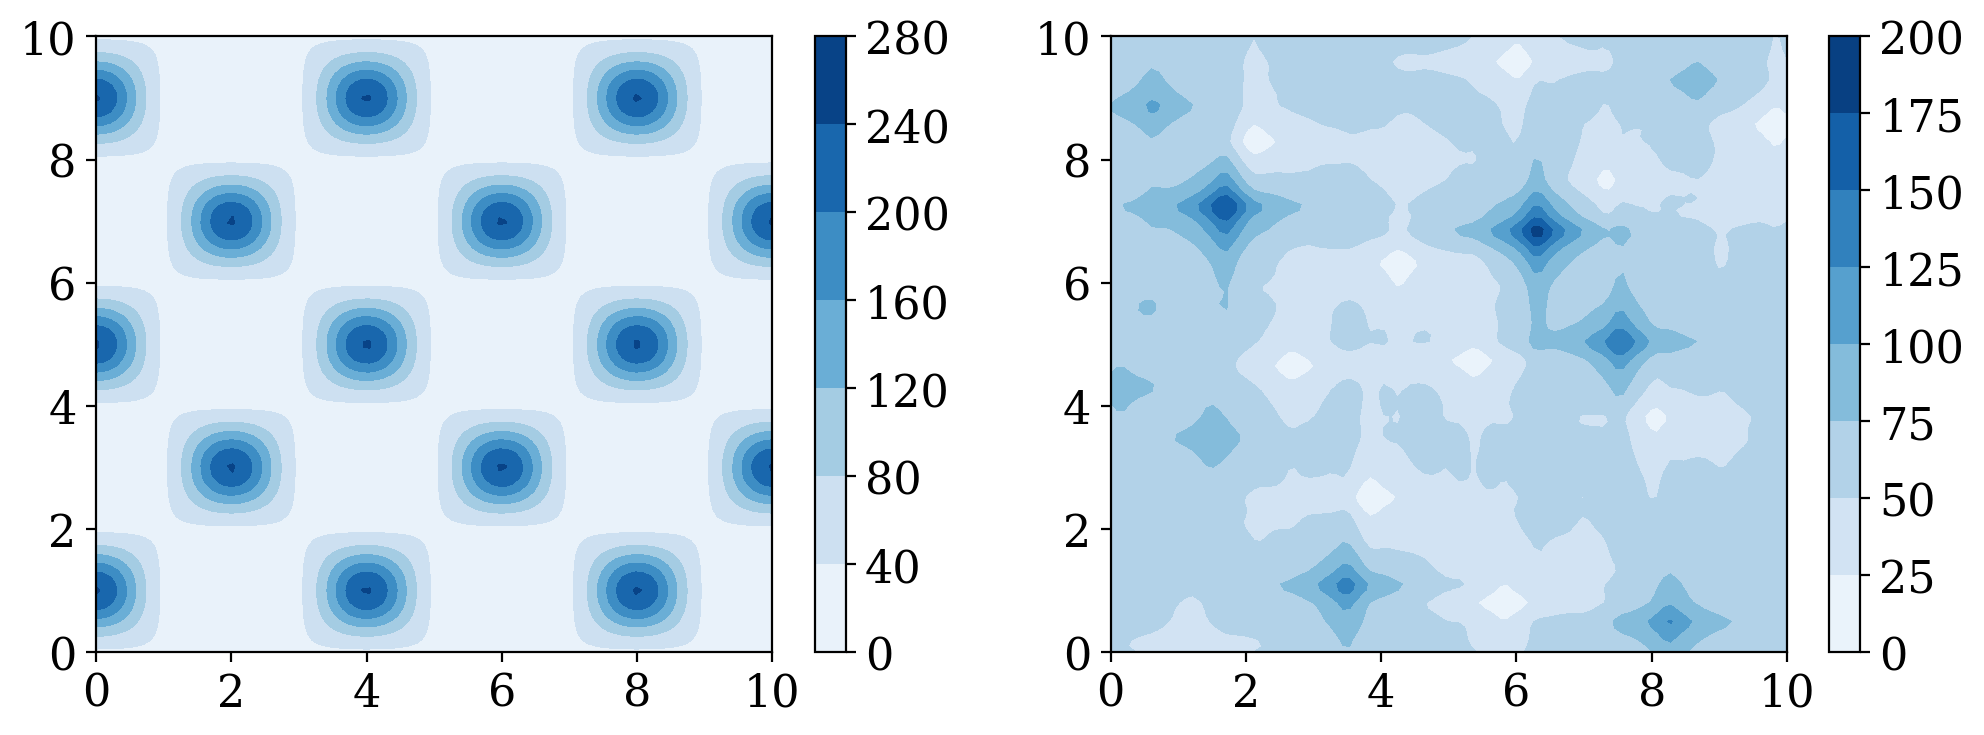

In [35]:
x = jnp.linspace(0,10, 100)
y = jnp.linspace(0,10, 100)
xx, yy = jnp.meshgrid(x, y)
grid = jnp.vstack([xx.ravel(), yy.ravel()]).T
print(grid.shape)

vals = loglike(grid)

unit_grid = input_standardize(grid)

post = lambda x: gp.posterior(x,single=True,unstandardize=True)
mu, var = vmap(post,in_axes=(0,),out_axes=(0,0))(unit_grid)

vals = vals.reshape(x.shape[0],y.shape[0])
mu = mu.reshape(x.shape[0],y.shape[0])
print(vals.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
cont1 = ax1.contourf(x,y,vals,cmap='Blues')
fig.colorbar(cont1,ax=ax1)
cont2 = ax2.contourf(x,y,mu,cmap='Blues')
fig.colorbar(cont2,ax=ax2)


In [36]:
def plot_gp(gp,fig,ax1,ax2):
    cont1 = ax1.contourf(x,y,vals,cmap='Blues')
    fig.colorbar(cont1,ax=ax1)
    post = lambda x: gp.posterior(x,single=True,unstandardize=True)
    mu, var = vmap(post,in_axes=(0,),out_axes=(0,0))(unit_grid)
    mu = mu.reshape(x.shape[0],y.shape[0])
    cont2 = ax2.contourf(x,y,mu,cmap='Blues')
    fig.colorbar(cont2,ax=ax2)
    ax2.scatter(train_x[:ninit,0],train_x[:ninit,1],color='C2',s=20)
    ax2.scatter(train_x[ninit:,0],train_x[ninit:,1],color='C3',s=20)

def plot_hypers(gp,ax):
    colors = matplotlib.colormaps['YlGn']
    l = np.array(gp.samples["kernel_length"])
    lp = -np.array(gp.samples["minus_log_prob"])
    lp_min, lp_max = np.min(lp), np.max(lp)
    cols = np.linspace(lp_min,lp_max,len(lp))
    cols = (cols - lp_min)/(lp_max - lp_min)
    sc = ax.scatter(l[:,0],l[:,1],c = lp, 
                    vmin = lp_min, vmax=lp_max,cmap= colors)
    fig.colorbar(sc,ax=ax)
    ax.set(xlabel=r'lengthscale 1',ylabel=r'lengthscale 2')



Nested Sampling took 2.67s
jaxns did 38639 likelihood evaluations
Acquisition optimization took 2.52 s


sample: 100%|██████████| 512/512 [00:03<00:00, 156.95it/s, 7 steps of size 3.81e-01. acc. prob=0.77] 



MCMC elapsed time: 3.45s
LogZ info :logz_mean: = 179.3746, dlogz: = 0.4871, 
Next point at x = [0.87040781 0.03306268] with acquisition function value = -0.005527023548881711
----------------------Step 1 complete----------------------

Nested Sampling took 2.00s
jaxns did 41555 likelihood evaluations
Acquisition optimization took 2.74 s


sample: 100%|██████████| 512/512 [00:02<00:00, 250.48it/s, 15 steps of size 3.01e-01. acc. prob=0.82]



MCMC elapsed time: 2.20s
Nested Sampling took 1.81s
jaxns did 33531 likelihood evaluations
Acquisition optimization took 2.37 s


sample: 100%|██████████| 512/512 [00:02<00:00, 249.81it/s, 7 steps of size 3.59e-01. acc. prob=0.78] 



MCMC elapsed time: 2.18s
Nested Sampling took 1.86s
jaxns did 38751 likelihood evaluations
Acquisition optimization took 1.93 s


sample: 100%|██████████| 512/512 [00:02<00:00, 171.95it/s, 7 steps of size 3.89e-01. acc. prob=0.89] 



MCMC elapsed time: 3.17s
Nested Sampling took 2.54s
jaxns did 31459 likelihood evaluations
Acquisition optimization took 2.30 s


sample: 100%|██████████| 512/512 [00:01<00:00, 262.32it/s, 3 steps of size 5.00e-01. acc. prob=0.83] 



MCMC elapsed time: 2.13s
Nested Sampling took 1.92s
jaxns did 33545 likelihood evaluations
Acquisition optimization took 1.98 s


sample: 100%|██████████| 512/512 [00:01<00:00, 269.51it/s, 7 steps of size 5.88e-01. acc. prob=0.89] 



MCMC elapsed time: 2.06s
LogZ info :logz_mean: = 186.4574, dlogz: = 0.4629, 
Next point at x = [0.63200448 0.64780266] with acquisition function value = -0.05413015719141323
----------------------Step 6 complete----------------------

Nested Sampling took 1.77s
jaxns did 31406 likelihood evaluations
Acquisition optimization took 3.14 s


sample: 100%|██████████| 512/512 [00:01<00:00, 278.43it/s, 7 steps of size 5.75e-01. acc. prob=0.88] 



MCMC elapsed time: 2.01s
Nested Sampling took 1.89s
jaxns did 29843 likelihood evaluations
Acquisition optimization took 2.65 s


sample: 100%|██████████| 512/512 [00:01<00:00, 275.72it/s, 7 steps of size 5.77e-01. acc. prob=0.90] 



MCMC elapsed time: 2.02s
Nested Sampling took 1.76s
jaxns did 31782 likelihood evaluations
Acquisition optimization took 3.26 s


sample: 100%|██████████| 512/512 [00:01<00:00, 287.61it/s, 7 steps of size 6.46e-01. acc. prob=0.84] 



MCMC elapsed time: 2.39s
Nested Sampling took 2.42s
jaxns did 30877 likelihood evaluations
Acquisition optimization took 4.64 s


sample: 100%|██████████| 512/512 [00:01<00:00, 273.29it/s, 7 steps of size 6.38e-01. acc. prob=0.90] 



MCMC elapsed time: 2.49s
Nested Sampling took 2.32s
jaxns did 27263 likelihood evaluations
Acquisition optimization took 3.04 s


sample: 100%|██████████| 512/512 [00:01<00:00, 279.51it/s, 7 steps of size 6.45e-01. acc. prob=0.90] 



MCMC elapsed time: 2.50s
LogZ info :logz_mean: = 228.5356, dlogz: = 0.4727, 
Next point at x = [0.12479723 0.70790134] with acquisition function value = -0.006811912893063553
----------------------Step 11 complete----------------------

Nested Sampling took 1.82s
jaxns did 29051 likelihood evaluations
Acquisition optimization took 3.24 s


sample: 100%|██████████| 512/512 [00:01<00:00, 265.41it/s, 7 steps of size 6.62e-01. acc. prob=0.92] 



MCMC elapsed time: 2.57s
Nested Sampling took 1.76s
jaxns did 31385 likelihood evaluations
Acquisition optimization took 3.63 s


sample: 100%|██████████| 512/512 [00:01<00:00, 280.00it/s, 7 steps of size 6.17e-01. acc. prob=0.87] 



MCMC elapsed time: 2.47s
Nested Sampling took 1.83s
jaxns did 28052 likelihood evaluations
Acquisition optimization took 2.67 s


sample: 100%|██████████| 512/512 [00:01<00:00, 268.39it/s, 7 steps of size 6.64e-01. acc. prob=0.89] 



MCMC elapsed time: 2.64s
Nested Sampling took 1.77s
jaxns did 30182 likelihood evaluations
Acquisition optimization took 4.32 s


sample: 100%|██████████| 512/512 [00:01<00:00, 277.70it/s, 7 steps of size 6.35e-01. acc. prob=0.90]



MCMC elapsed time: 2.56s
Nested Sampling took 1.87s
jaxns did 31126 likelihood evaluations
Acquisition optimization took 3.54 s


sample: 100%|██████████| 512/512 [00:01<00:00, 259.64it/s, 7 steps of size 5.42e-01. acc. prob=0.91] 



MCMC elapsed time: 2.69s
LogZ info :logz_mean: = 230.3321, dlogz: = 0.4987, 
Next point at x = [0.19646902 0.68392068] with acquisition function value = -0.018532266160670812
----------------------Step 16 complete----------------------

Nested Sampling took 1.78s
jaxns did 25222 likelihood evaluations
Acquisition optimization took 3.35 s


sample: 100%|██████████| 512/512 [00:02<00:00, 228.33it/s, 7 steps of size 5.55e-01. acc. prob=0.93] 



MCMC elapsed time: 2.98s
Nested Sampling took 1.90s
jaxns did 27887 likelihood evaluations
Acquisition optimization took 3.27 s


sample: 100%|██████████| 512/512 [00:02<00:00, 224.81it/s, 7 steps of size 6.65e-01. acc. prob=0.87]



MCMC elapsed time: 3.03s
Nested Sampling took 1.85s
jaxns did 30417 likelihood evaluations
Acquisition optimization took 1.81 s


sample: 100%|██████████| 512/512 [00:02<00:00, 253.93it/s, 7 steps of size 6.39e-01. acc. prob=0.91] 



MCMC elapsed time: 2.78s
Nested Sampling took 1.86s
jaxns did 30339 likelihood evaluations
Acquisition optimization took 2.61 s


sample: 100%|██████████| 512/512 [00:02<00:00, 229.57it/s, 7 steps of size 6.32e-01. acc. prob=0.89]



MCMC elapsed time: 2.90s
Nested Sampling took 2.01s
jaxns did 30328 likelihood evaluations
Acquisition optimization took 1.86 s


sample: 100%|██████████| 512/512 [00:02<00:00, 190.84it/s, 7 steps of size 6.42e-01. acc. prob=0.90] 



MCMC elapsed time: 3.49s
LogZ info :logz_mean: = 231.7108, dlogz: = 0.4545, 
Next point at x = [0.         0.80930371] with acquisition function value = -0.007031165198114167
----------------------Step 21 complete----------------------

Nested Sampling took 1.85s
jaxns did 26959 likelihood evaluations
Acquisition optimization took 3.58 s


sample: 100%|██████████| 512/512 [00:02<00:00, 235.99it/s, 7 steps of size 5.73e-01. acc. prob=0.92] 



MCMC elapsed time: 2.93s
Nested Sampling took 2.96s
jaxns did 28829 likelihood evaluations
Acquisition optimization took 3.56 s


sample: 100%|██████████| 512/512 [00:04<00:00, 127.30it/s, 7 steps of size 5.68e-01. acc. prob=0.93] 



MCMC elapsed time: 4.83s
Nested Sampling took 1.99s
jaxns did 27453 likelihood evaluations
Acquisition optimization took 2.41 s


sample: 100%|██████████| 512/512 [00:02<00:00, 187.63it/s, 7 steps of size 6.79e-01. acc. prob=0.87] 



MCMC elapsed time: 3.54s
Nested Sampling took 2.58s
jaxns did 24904 likelihood evaluations
Acquisition optimization took 3.00 s


sample: 100%|██████████| 512/512 [00:02<00:00, 196.80it/s, 7 steps of size 6.68e-01. acc. prob=0.89] 



MCMC elapsed time: 3.34s
Nested Sampling took 2.05s
jaxns did 30478 likelihood evaluations
Acquisition optimization took 3.36 s


sample: 100%|██████████| 512/512 [00:02<00:00, 191.51it/s, 7 steps of size 6.84e-01. acc. prob=0.89] 



MCMC elapsed time: 3.45s
LogZ info :logz_mean: = 234.1896, dlogz: = 0.4421, 
Next point at x = [0.80232794 0.4889426 ] with acquisition function value = -0.05027135355676378
----------------------Step 26 complete----------------------

Nested Sampling took 1.85s
jaxns did 29941 likelihood evaluations
Acquisition optimization took 2.75 s


sample: 100%|██████████| 512/512 [00:02<00:00, 193.26it/s, 7 steps of size 6.43e-01. acc. prob=0.91] 



MCMC elapsed time: 3.49s
Nested Sampling took 2.07s
jaxns did 26800 likelihood evaluations
Acquisition optimization took 2.57 s


sample: 100%|██████████| 512/512 [00:03<00:00, 144.67it/s, 7 steps of size 6.62e-01. acc. prob=0.89] 



MCMC elapsed time: 4.33s
Nested Sampling took 2.02s
jaxns did 29010 likelihood evaluations
Acquisition optimization took 2.48 s


sample: 100%|██████████| 512/512 [00:02<00:00, 202.00it/s, 15 steps of size 7.11e-01. acc. prob=0.87]



MCMC elapsed time: 4.07s
Nested Sampling took 1.82s
jaxns did 27219 likelihood evaluations
Acquisition optimization took 2.61 s


sample: 100%|██████████| 512/512 [00:02<00:00, 231.98it/s, 7 steps of size 6.92e-01. acc. prob=0.89] 



MCMC elapsed time: 2.88s
Nested Sampling took 1.78s
jaxns did 27364 likelihood evaluations
Acquisition optimization took 1.87 s


sample: 100%|██████████| 512/512 [00:02<00:00, 208.43it/s, 7 steps of size 6.45e-01. acc. prob=0.92] 



MCMC elapsed time: 3.29s
LogZ info :logz_mean: = 233.6057, dlogz: = 0.4245, 
Next point at x = [0.         0.21716664] with acquisition function value = -0.012249910938531554
----------------------Step 31 complete----------------------

Nested Sampling took 1.93s
jaxns did 26702 likelihood evaluations
Acquisition optimization took 2.18 s


sample: 100%|██████████| 512/512 [00:02<00:00, 188.14it/s, 7 steps of size 6.08e-01. acc. prob=0.91] 



MCMC elapsed time: 3.42s
Nested Sampling took 2.07s
jaxns did 27361 likelihood evaluations
Acquisition optimization took 1.49 s


sample: 100%|██████████| 512/512 [00:03<00:00, 136.33it/s, 7 steps of size 6.36e-01. acc. prob=0.90] 



MCMC elapsed time: 4.71s
Nested Sampling took 2.06s
jaxns did 26214 likelihood evaluations
Acquisition optimization took 1.90 s


sample: 100%|██████████| 512/512 [00:06<00:00, 78.12it/s, 7 steps of size 7.02e-01. acc. prob=0.88] 



MCMC elapsed time: 7.70s
Nested Sampling took 1.99s
jaxns did 27572 likelihood evaluations
Acquisition optimization took 3.02 s


sample: 100%|██████████| 512/512 [00:04<00:00, 105.89it/s, 7 steps of size 7.11e-01. acc. prob=0.85] 



MCMC elapsed time: 5.99s
Nested Sampling took 1.88s
jaxns did 25528 likelihood evaluations
Acquisition optimization took 2.58 s


sample: 100%|██████████| 512/512 [00:03<00:00, 168.98it/s, 7 steps of size 5.42e-01. acc. prob=0.94] 



MCMC elapsed time: 4.07s
LogZ info :logz_mean: = 233.9795, dlogz: = 0.4374, 
Next point at x = [1. 1.] with acquisition function value = -0.00672181551802392
----------------------Step 36 complete----------------------

Nested Sampling took 1.87s
jaxns did 27767 likelihood evaluations
Acquisition optimization took 1.83 s


sample: 100%|██████████| 512/512 [00:03<00:00, 149.72it/s, 7 steps of size 6.84e-01. acc. prob=0.89] 



MCMC elapsed time: 5.46s
Nested Sampling took 2.16s
jaxns did 26600 likelihood evaluations
Acquisition optimization took 2.01 s


sample: 100%|██████████| 512/512 [00:05<00:00, 89.27it/s, 7 steps of size 5.57e-01. acc. prob=0.93]  



MCMC elapsed time: 6.91s
Nested Sampling took 2.37s
jaxns did 28458 likelihood evaluations
Acquisition optimization took 3.53 s


sample: 100%|██████████| 512/512 [00:03<00:00, 131.23it/s, 7 steps of size 6.69e-01. acc. prob=0.92] 



MCMC elapsed time: 5.02s
Nested Sampling took 2.07s
jaxns did 26601 likelihood evaluations
Acquisition optimization took 3.25 s


sample: 100%|██████████| 512/512 [00:05<00:00, 92.71it/s, 7 steps of size 7.27e-01. acc. prob=0.87]  



MCMC elapsed time: 6.62s
Nested Sampling took 2.37s
jaxns did 29182 likelihood evaluations
Acquisition optimization took 2.86 s


sample: 100%|██████████| 512/512 [00:03<00:00, 131.95it/s, 7 steps of size 6.23e-01. acc. prob=0.90] 



MCMC elapsed time: 5.09s
LogZ info :logz_mean: = 234.2799, dlogz: = 0.4351, 
Next point at x = [0.59937104 0.35055064] with acquisition function value = -0.0137192388541146
----------------------Step 41 complete----------------------

Nested Sampling took 2.33s
jaxns did 29207 likelihood evaluations
Acquisition optimization took 3.14 s


sample: 100%|██████████| 512/512 [00:04<00:00, 103.37it/s, 7 steps of size 6.31e-01. acc. prob=0.89] 



MCMC elapsed time: 6.15s
Nested Sampling took 2.21s
jaxns did 29031 likelihood evaluations
Acquisition optimization took 2.33 s


sample: 100%|██████████| 512/512 [00:05<00:00, 99.98it/s, 7 steps of size 6.92e-01. acc. prob=0.89]  



MCMC elapsed time: 6.28s
Nested Sampling took 2.28s
jaxns did 25746 likelihood evaluations
Acquisition optimization took 3.05 s


sample: 100%|██████████| 512/512 [00:03<00:00, 156.51it/s, 3 steps of size 7.24e-01. acc. prob=0.90] 



MCMC elapsed time: 4.27s
Nested Sampling took 1.95s
jaxns did 27994 likelihood evaluations
Acquisition optimization took 3.30 s


sample: 100%|██████████| 512/512 [00:04<00:00, 119.24it/s, 3 steps of size 8.53e-01. acc. prob=0.84] 



MCMC elapsed time: 5.51s
Nested Sampling took 2.30s
jaxns did 27189 likelihood evaluations
Acquisition optimization took 2.29 s


sample: 100%|██████████| 512/512 [00:10<00:00, 50.33it/s, 7 steps of size 5.93e-01. acc. prob=0.89]  



MCMC elapsed time: 13.07s
LogZ info :logz_mean: = 233.7303, dlogz: = 0.4396, 
Next point at x = [0.40454169 0.51189396] with acquisition function value = -0.056735140446011176
----------------------Step 46 complete----------------------

Nested Sampling took 2.23s
jaxns did 58186 likelihood evaluations
Acquisition optimization took 1.10 s


sample: 100%|██████████| 512/512 [00:10<00:00, 48.64it/s, 7 steps of size 7.19e-01. acc. prob=0.88]  



MCMC elapsed time: 11.56s
Nested Sampling took 2.78s
jaxns did 27262 likelihood evaluations
Acquisition optimization took 2.25 s


sample: 100%|██████████| 512/512 [00:08<00:00, 63.17it/s, 7 steps of size 6.33e-01. acc. prob=0.91]  



MCMC elapsed time: 9.54s
Nested Sampling took 2.13s
jaxns did 26741 likelihood evaluations
Acquisition optimization took 2.43 s


sample: 100%|██████████| 512/512 [00:04<00:00, 107.22it/s, 3 steps of size 6.52e-01. acc. prob=0.90] 



MCMC elapsed time: 5.99s
Nested Sampling took 1.91s
jaxns did 25111 likelihood evaluations
Acquisition optimization took 1.99 s


sample: 100%|██████████| 512/512 [00:03<00:00, 138.96it/s, 7 steps of size 6.56e-01. acc. prob=0.90] 



MCMC elapsed time: 4.84s
Nested Sampling took 2.04s
jaxns did 26897 likelihood evaluations
Acquisition optimization took 2.94 s


sample: 100%|██████████| 512/512 [00:05<00:00, 96.50it/s, 7 steps of size 6.06e-01. acc. prob=0.89] 



MCMC elapsed time: 6.37s
LogZ info :logz_mean: = 233.3837, dlogz: = 0.4453, 
Next point at x = [0.         0.65353864] with acquisition function value = -0.010357288929808296
----------------------Step 51 complete----------------------

Nested Sampling took 2.22s
jaxns did 58300 likelihood evaluations
Acquisition optimization took 0.73 s


sample: 100%|██████████| 512/512 [00:07<00:00, 72.73it/s, 7 steps of size 6.84e-01. acc. prob=0.92]  



MCMC elapsed time: 8.29s
Nested Sampling took 1.97s
jaxns did 25120 likelihood evaluations
Acquisition optimization took 3.58 s


sample: 100%|██████████| 512/512 [00:05<00:00, 94.41it/s, 7 steps of size 7.20e-01. acc. prob=0.89]  



MCMC elapsed time: 6.62s
Nested Sampling took 2.35s
jaxns did 29499 likelihood evaluations
Acquisition optimization took 1.87 s


sample: 100%|██████████| 512/512 [00:04<00:00, 103.06it/s, 7 steps of size 6.58e-01. acc. prob=0.90] 



MCMC elapsed time: 6.08s
Nested Sampling took 2.07s
jaxns did 29055 likelihood evaluations
Acquisition optimization took 2.47 s


sample: 100%|██████████| 512/512 [00:04<00:00, 117.98it/s, 7 steps of size 7.37e-01. acc. prob=0.89] 



MCMC elapsed time: 5.47s
Nested Sampling took 2.02s
jaxns did 27770 likelihood evaluations
Acquisition optimization took 4.20 s


sample: 100%|██████████| 512/512 [00:04<00:00, 103.71it/s, 7 steps of size 6.83e-01. acc. prob=0.89] 



MCMC elapsed time: 6.08s
LogZ info :logz_mean: = 233.8638, dlogz: = 0.4430, 
Next point at x = [0.33951678 0.85488052] with acquisition function value = -0.006087115708635287
----------------------Step 56 complete----------------------

Nested Sampling took 2.92s
jaxns did 24670 likelihood evaluations
Acquisition optimization took 2.20 s


sample: 100%|██████████| 512/512 [00:05<00:00, 95.65it/s, 7 steps of size 6.89e-01. acc. prob=0.88]  



MCMC elapsed time: 6.63s
Nested Sampling took 2.38s
jaxns did 30157 likelihood evaluations
Acquisition optimization took 2.31 s


sample: 100%|██████████| 512/512 [00:05<00:00, 88.93it/s, 7 steps of size 6.25e-01. acc. prob=0.90]  



MCMC elapsed time: 7.03s
Nested Sampling took 2.06s
jaxns did 27924 likelihood evaluations
Acquisition optimization took 3.39 s


sample: 100%|██████████| 512/512 [00:06<00:00, 78.61it/s, 7 steps of size 6.25e-01. acc. prob=0.91]  



MCMC elapsed time: 7.86s
Nested Sampling took 2.35s
jaxns did 26630 likelihood evaluations
Acquisition optimization took 4.18 s


sample: 100%|██████████| 512/512 [00:05<00:00, 97.32it/s, 7 steps of size 6.93e-01. acc. prob=0.90]  



MCMC elapsed time: 6.36s
Nested Sampling took 2.03s
jaxns did 29067 likelihood evaluations
Acquisition optimization took 3.39 s


sample: 100%|██████████| 512/512 [00:04<00:00, 106.71it/s, 7 steps of size 7.42e-01. acc. prob=0.87]



MCMC elapsed time: 6.00s
LogZ info :logz_mean: = 233.9470, dlogz: = 0.4347, 
Next point at x = [0.25259222 0.32928778] with acquisition function value = -0.006015286729629458
----------------------Step 61 complete----------------------

Nested Sampling took 2.08s
jaxns did 25834 likelihood evaluations
Acquisition optimization took 2.11 s


sample: 100%|██████████| 512/512 [00:04<00:00, 102.59it/s, 7 steps of size 7.00e-01. acc. prob=0.90] 



MCMC elapsed time: 6.29s
Nested Sampling took 2.18s
jaxns did 28003 likelihood evaluations
Acquisition optimization took 2.61 s


sample: 100%|██████████| 512/512 [00:04<00:00, 106.32it/s, 7 steps of size 7.51e-01. acc. prob=0.85] 



MCMC elapsed time: 5.95s
Nested Sampling took 2.03s
jaxns did 26749 likelihood evaluations
Acquisition optimization took 3.59 s


sample: 100%|██████████| 512/512 [00:05<00:00, 98.62it/s, 7 steps of size 5.16e-01. acc. prob=0.91]  



MCMC elapsed time: 6.28s
BO took 653.20 s 


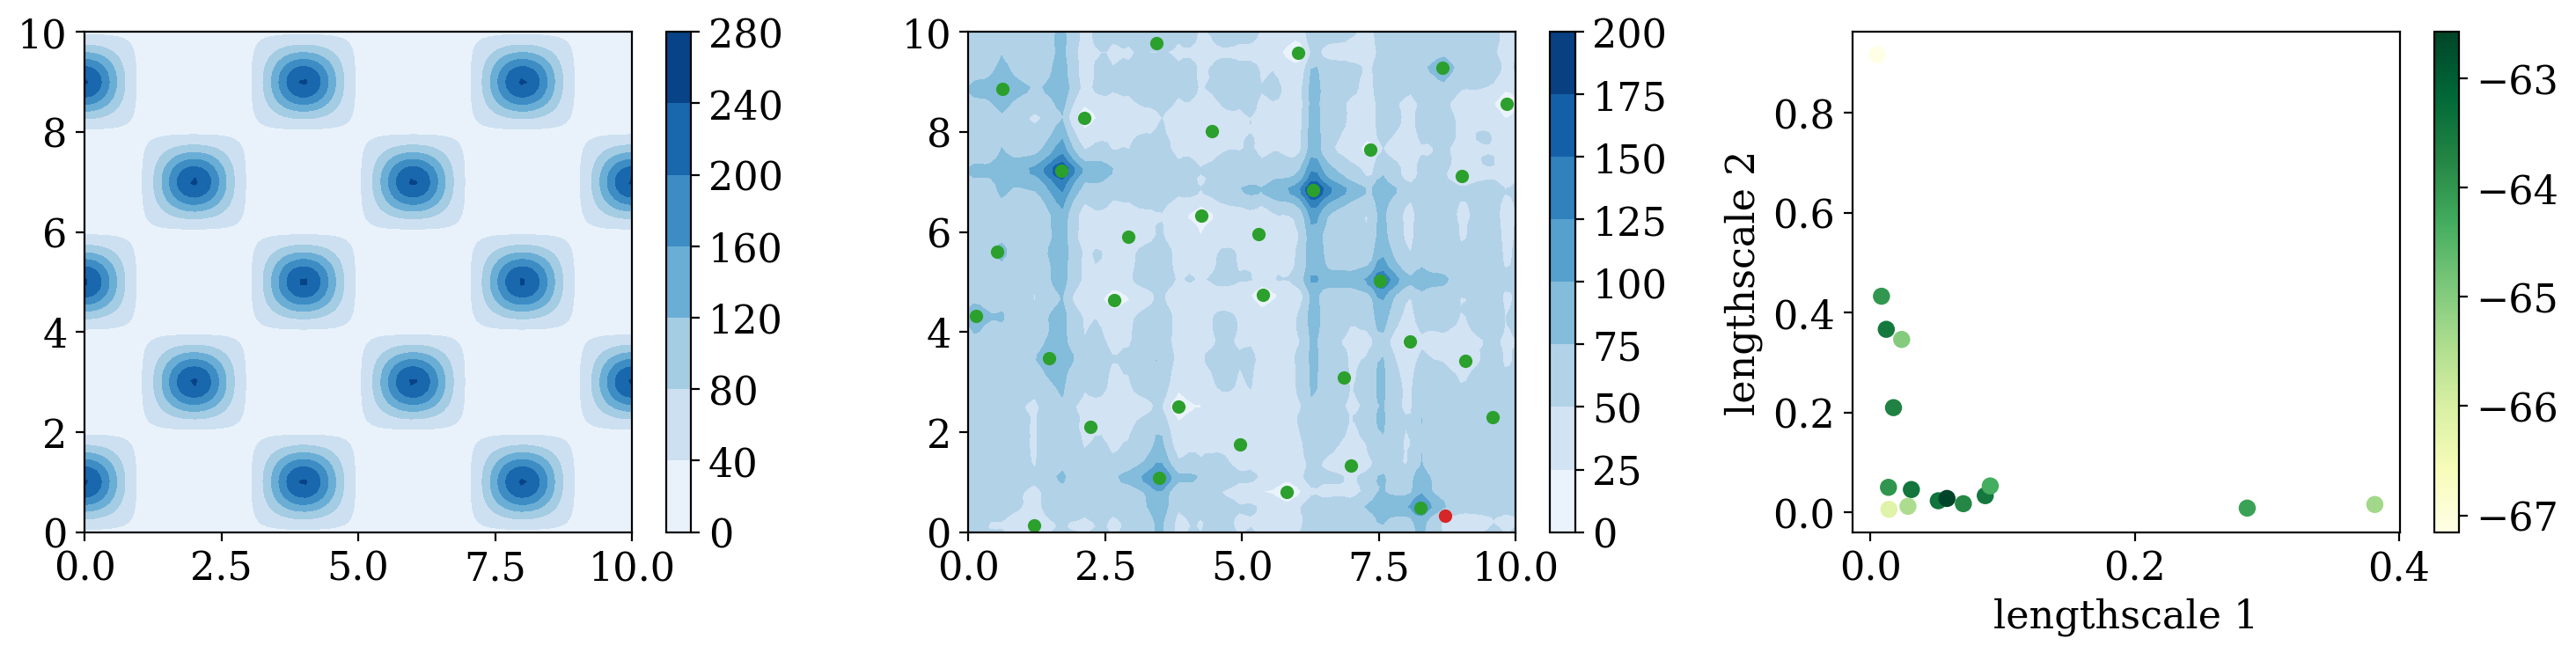

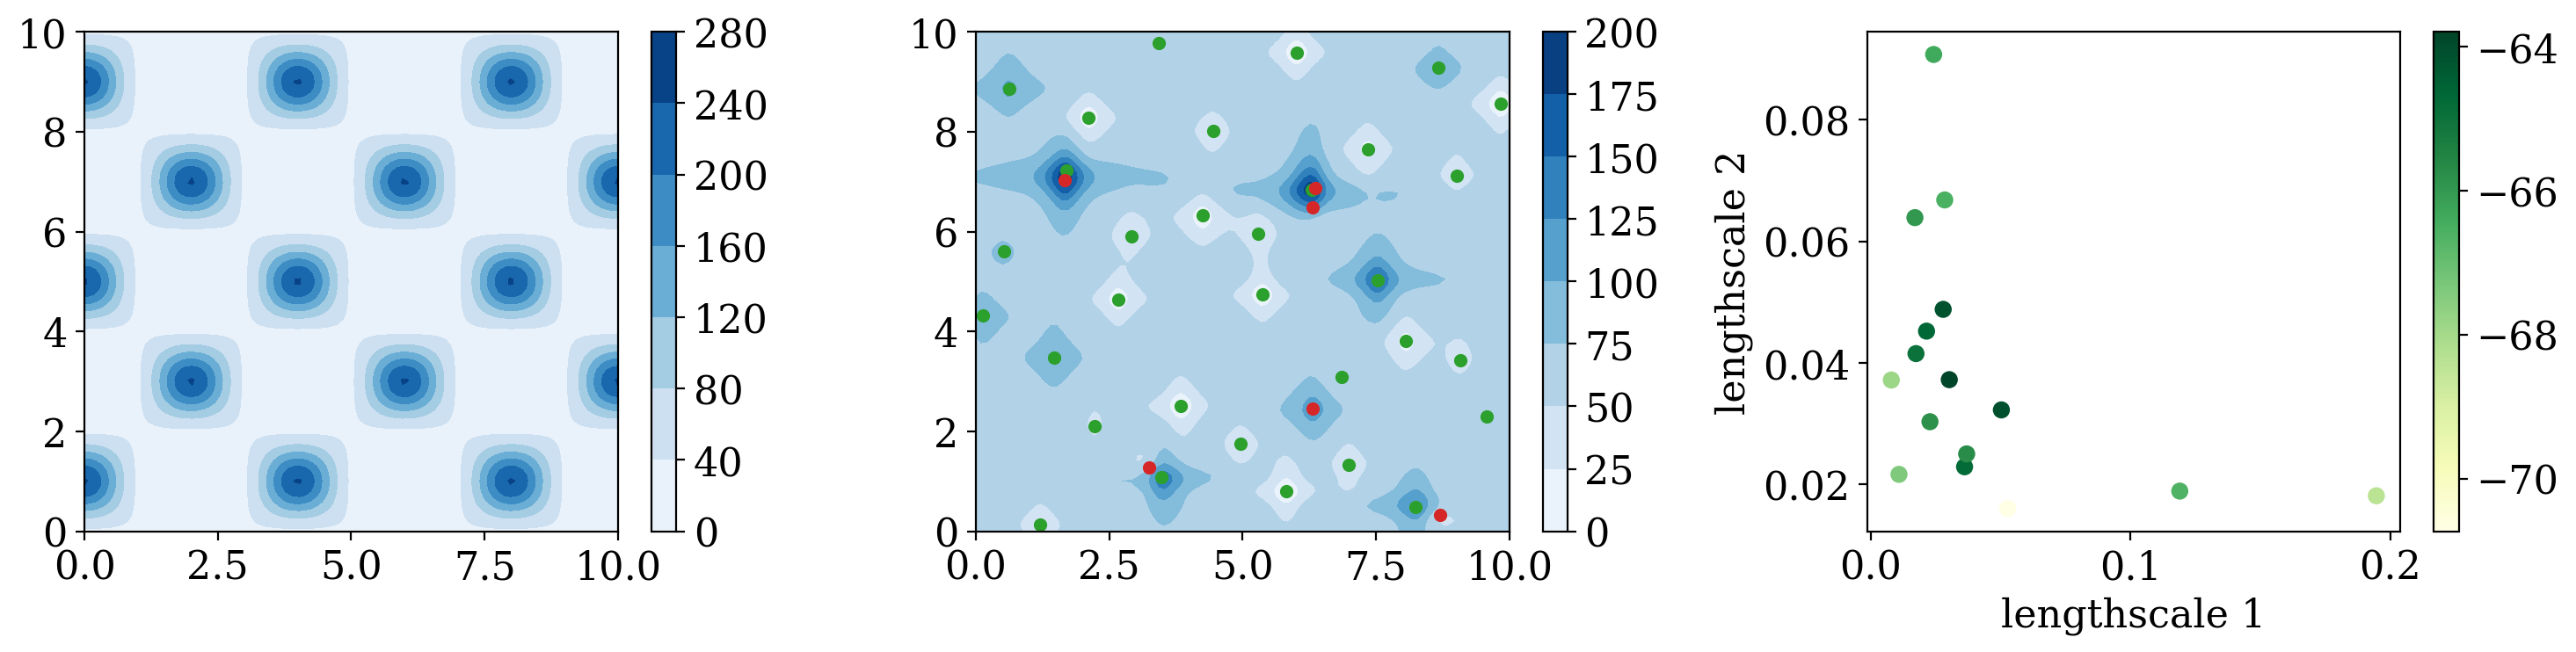

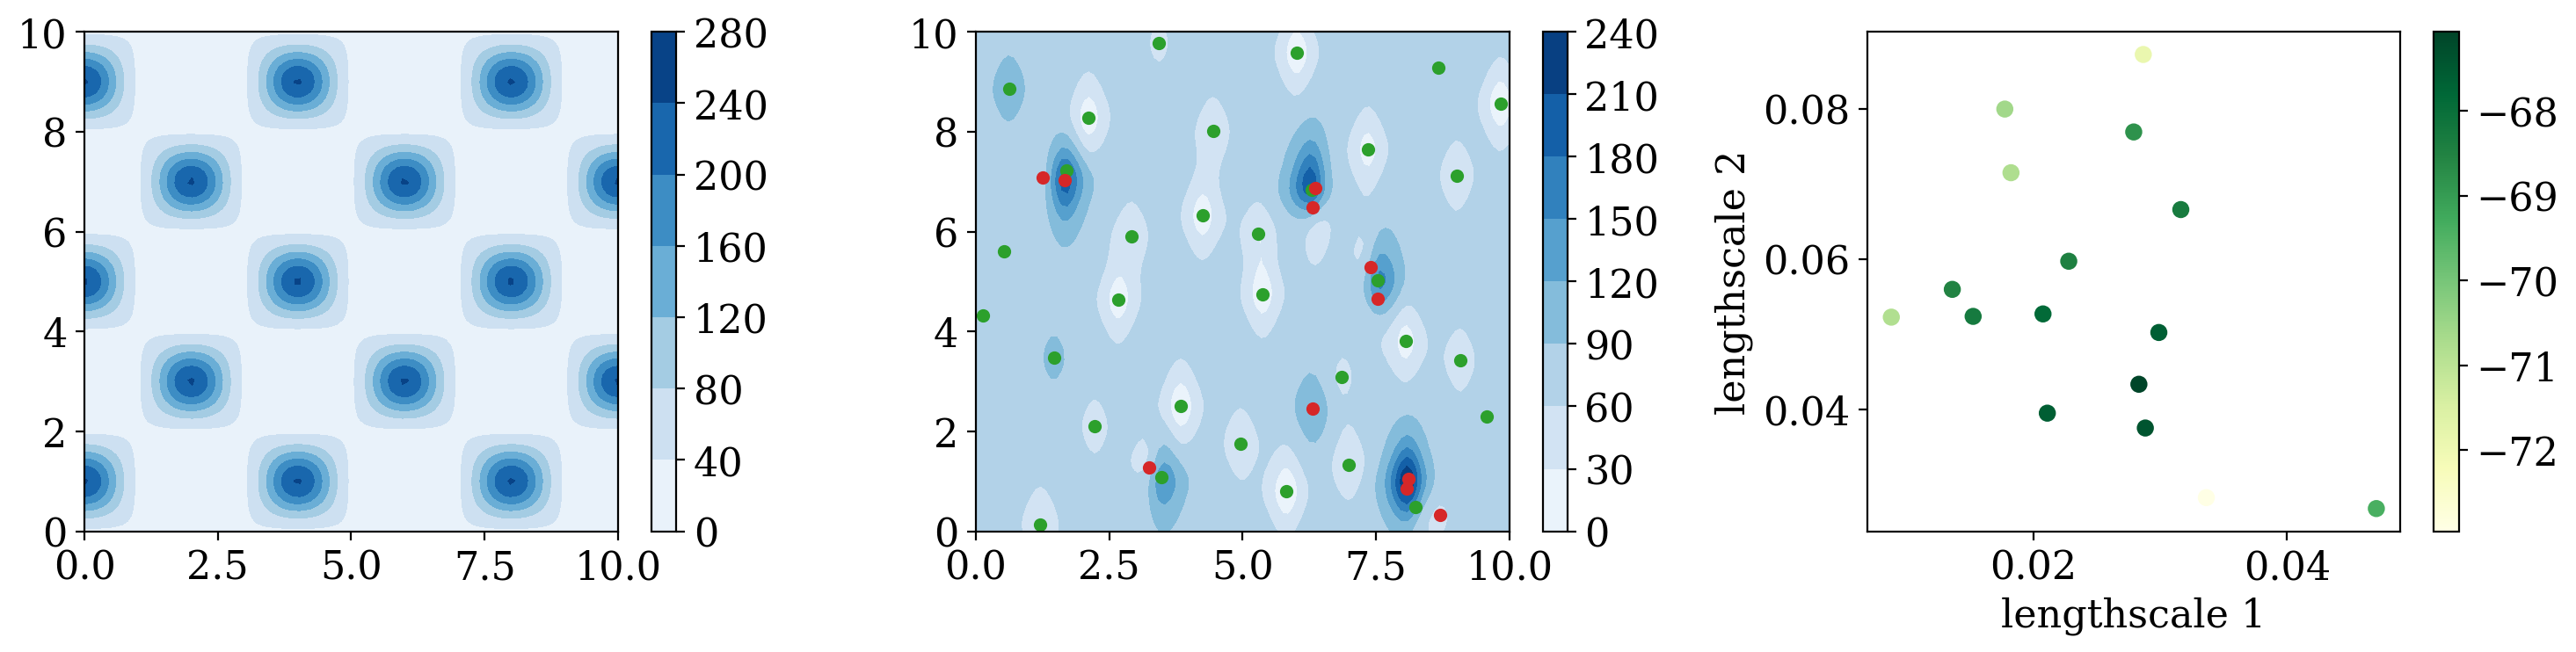

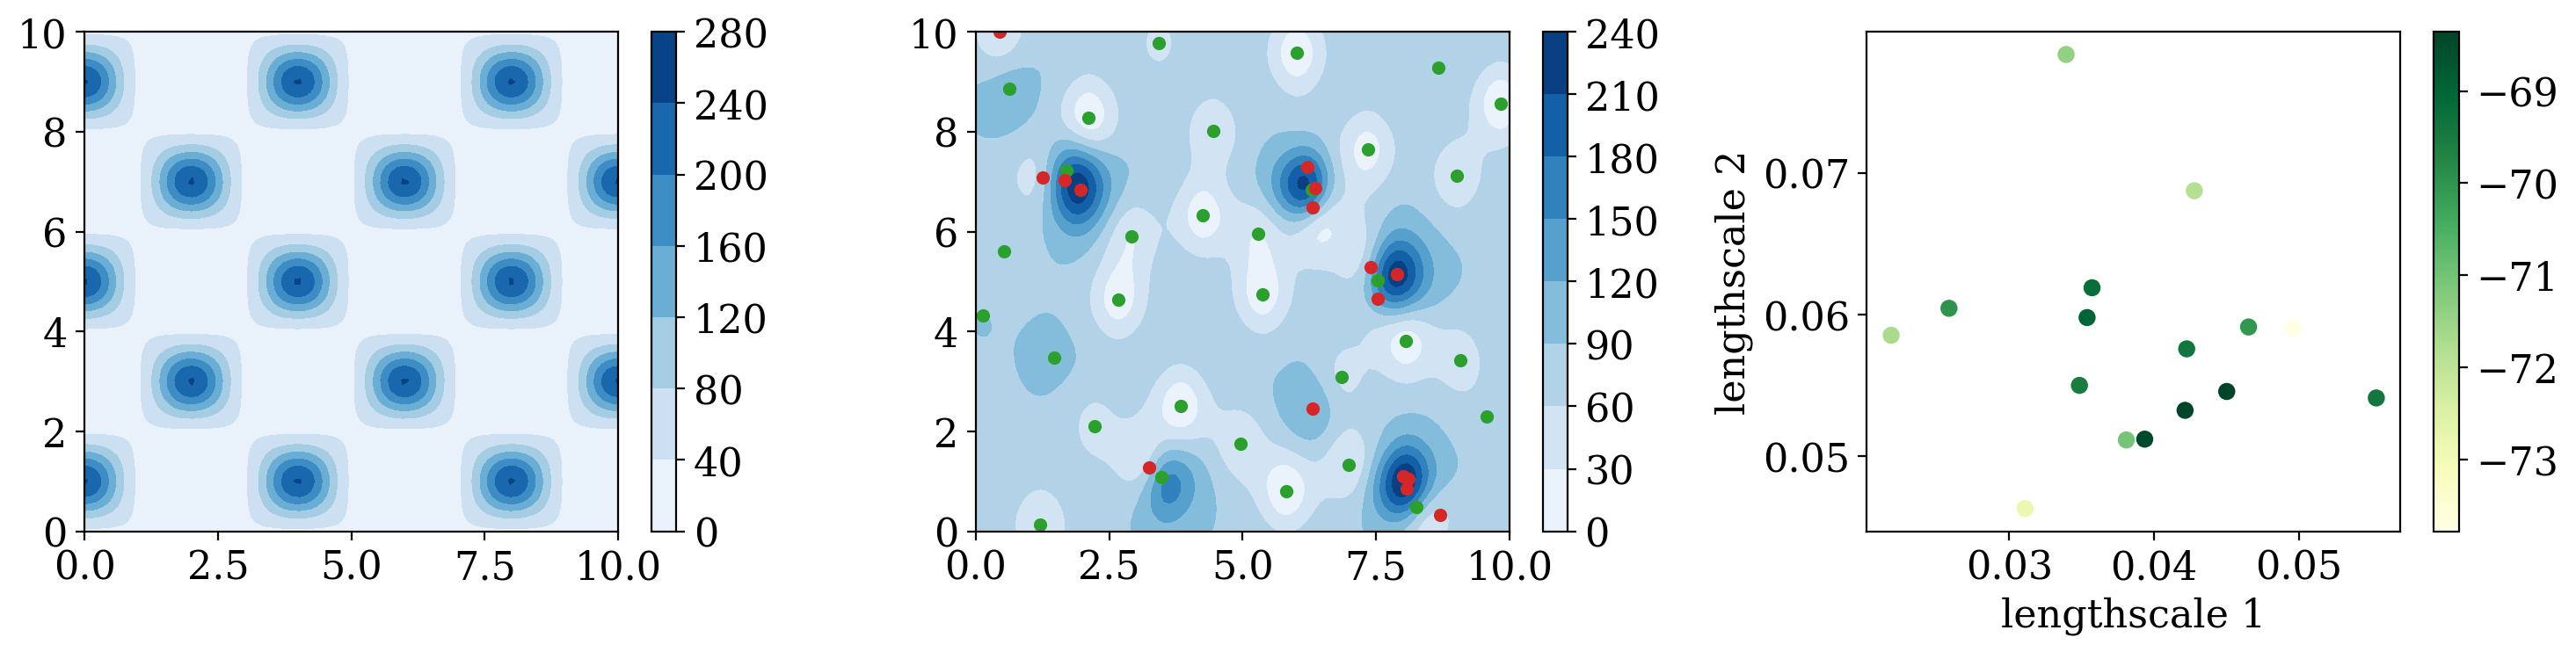

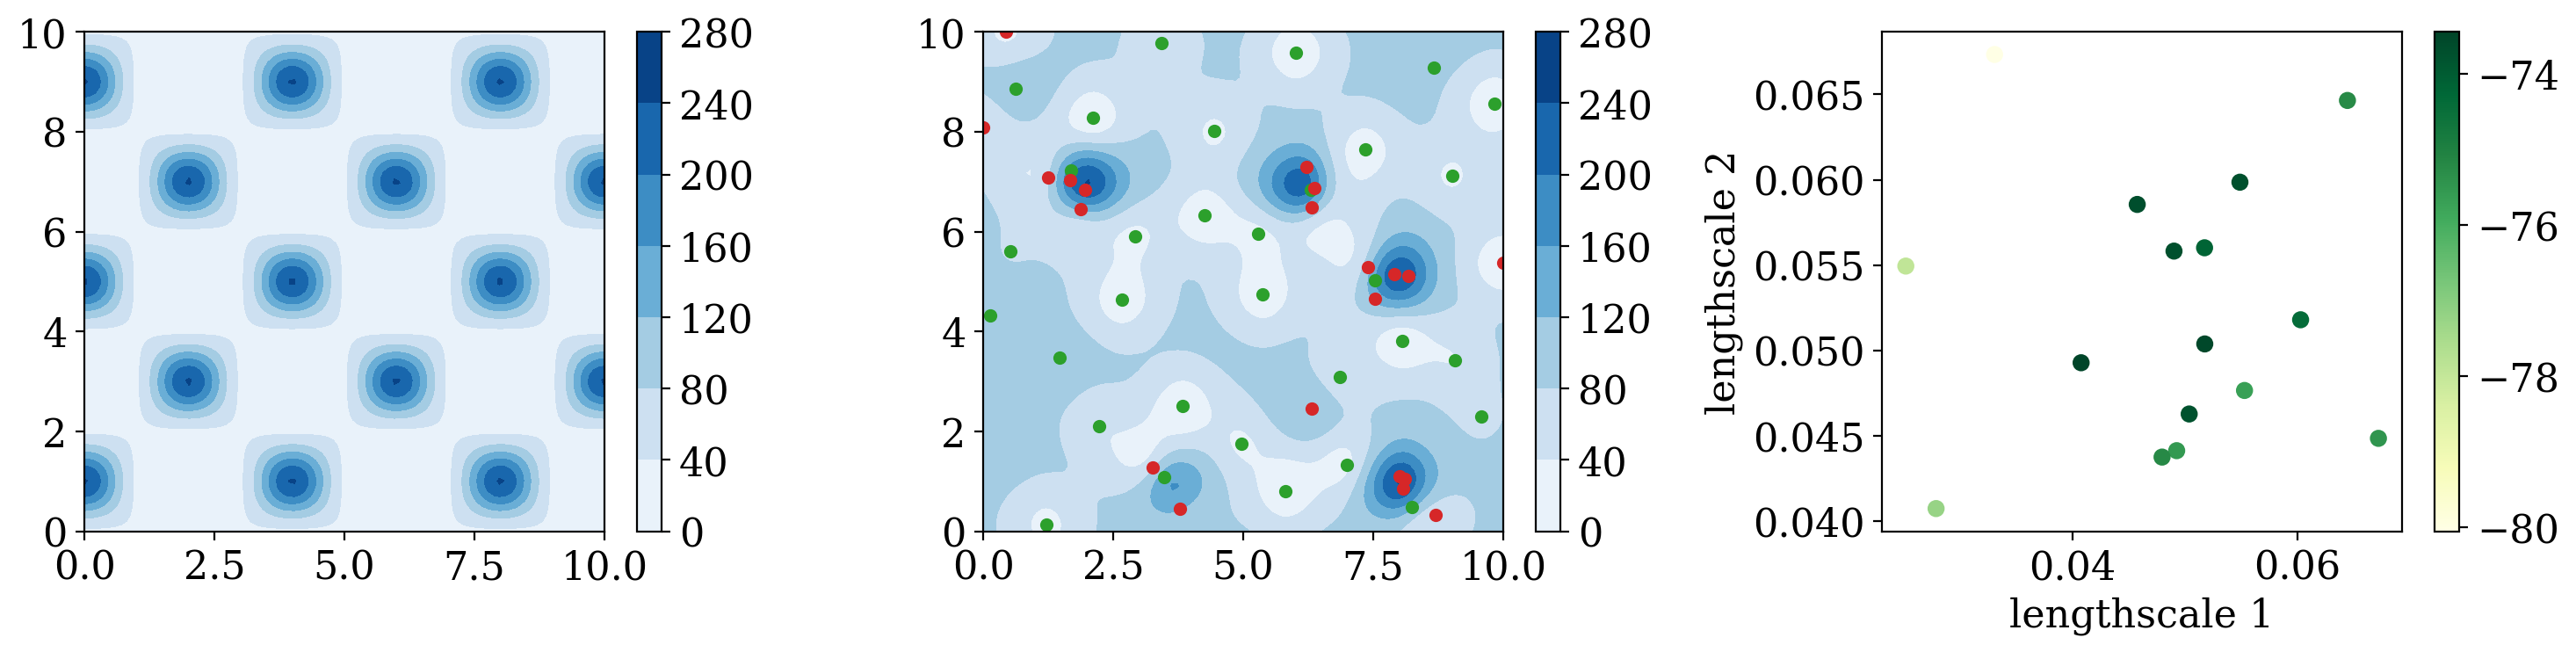

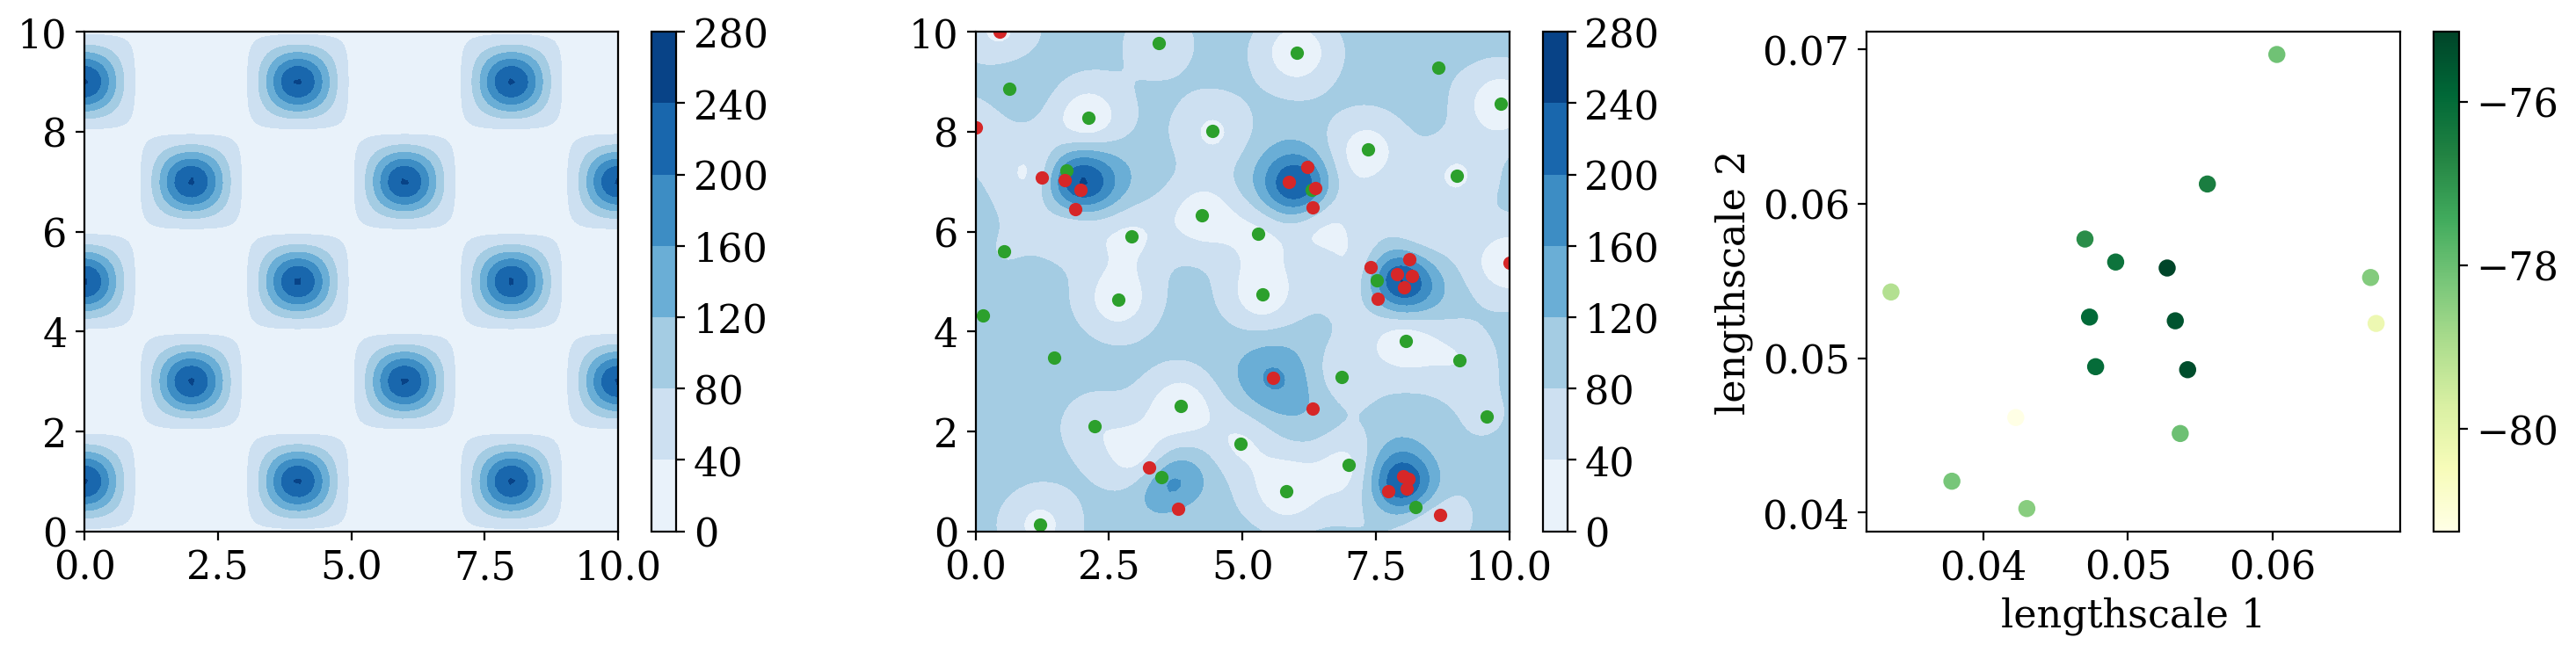

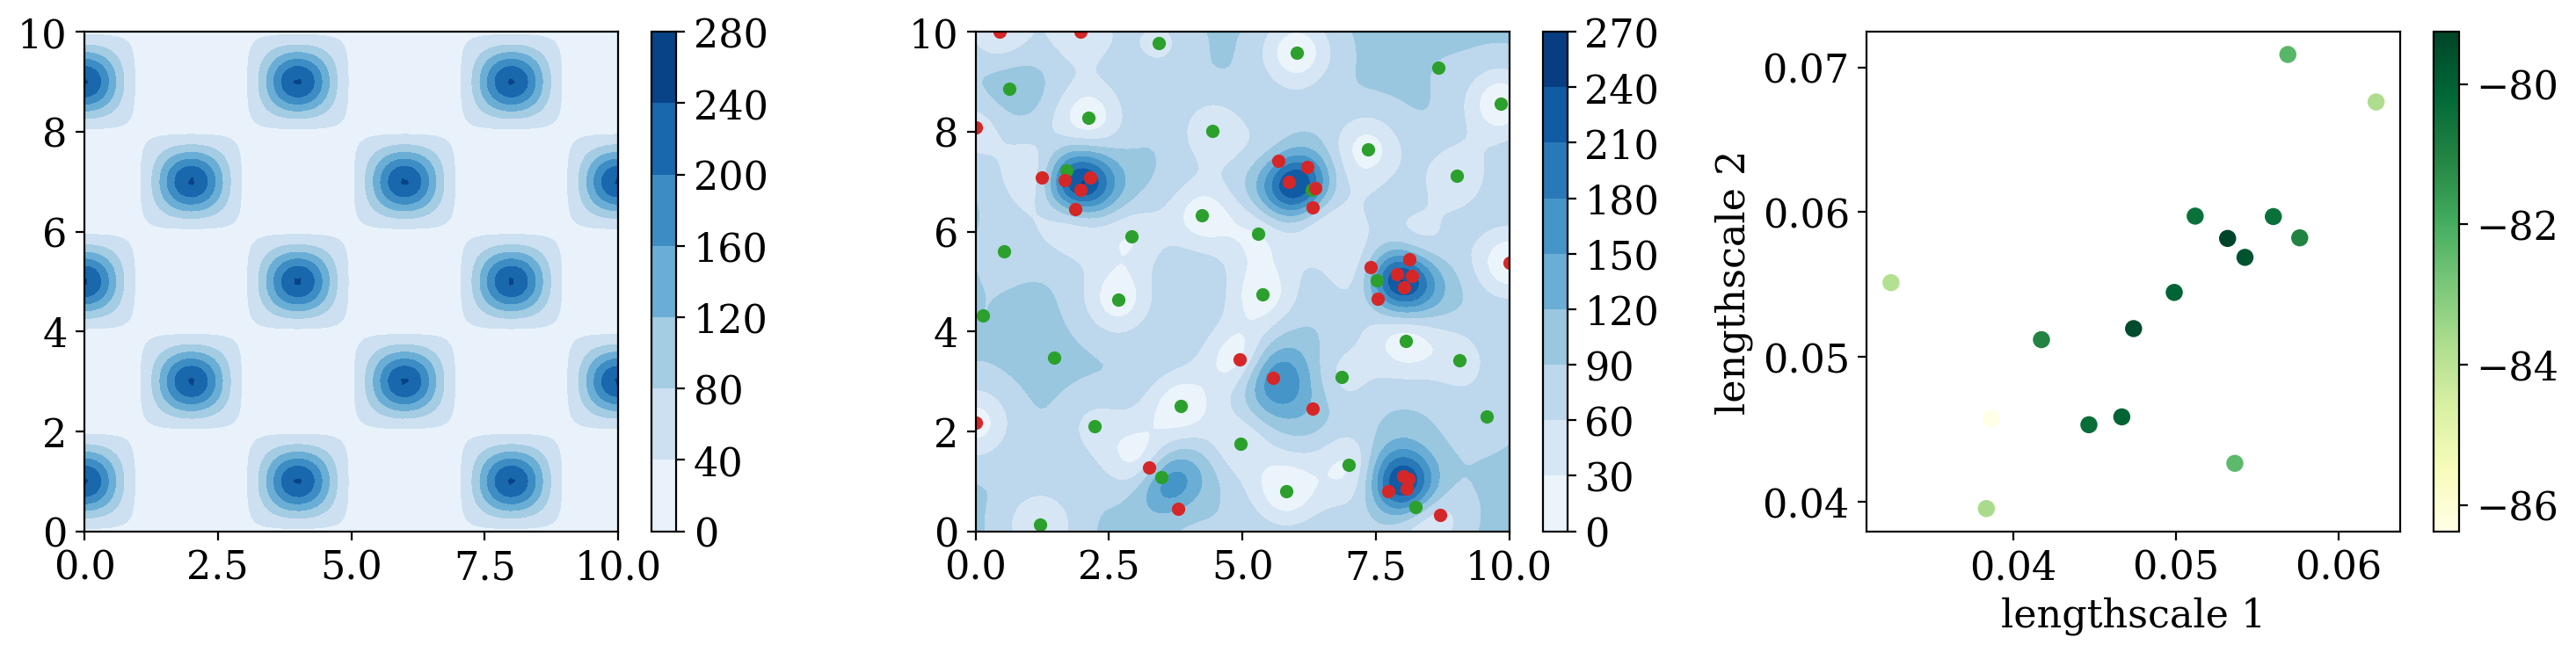

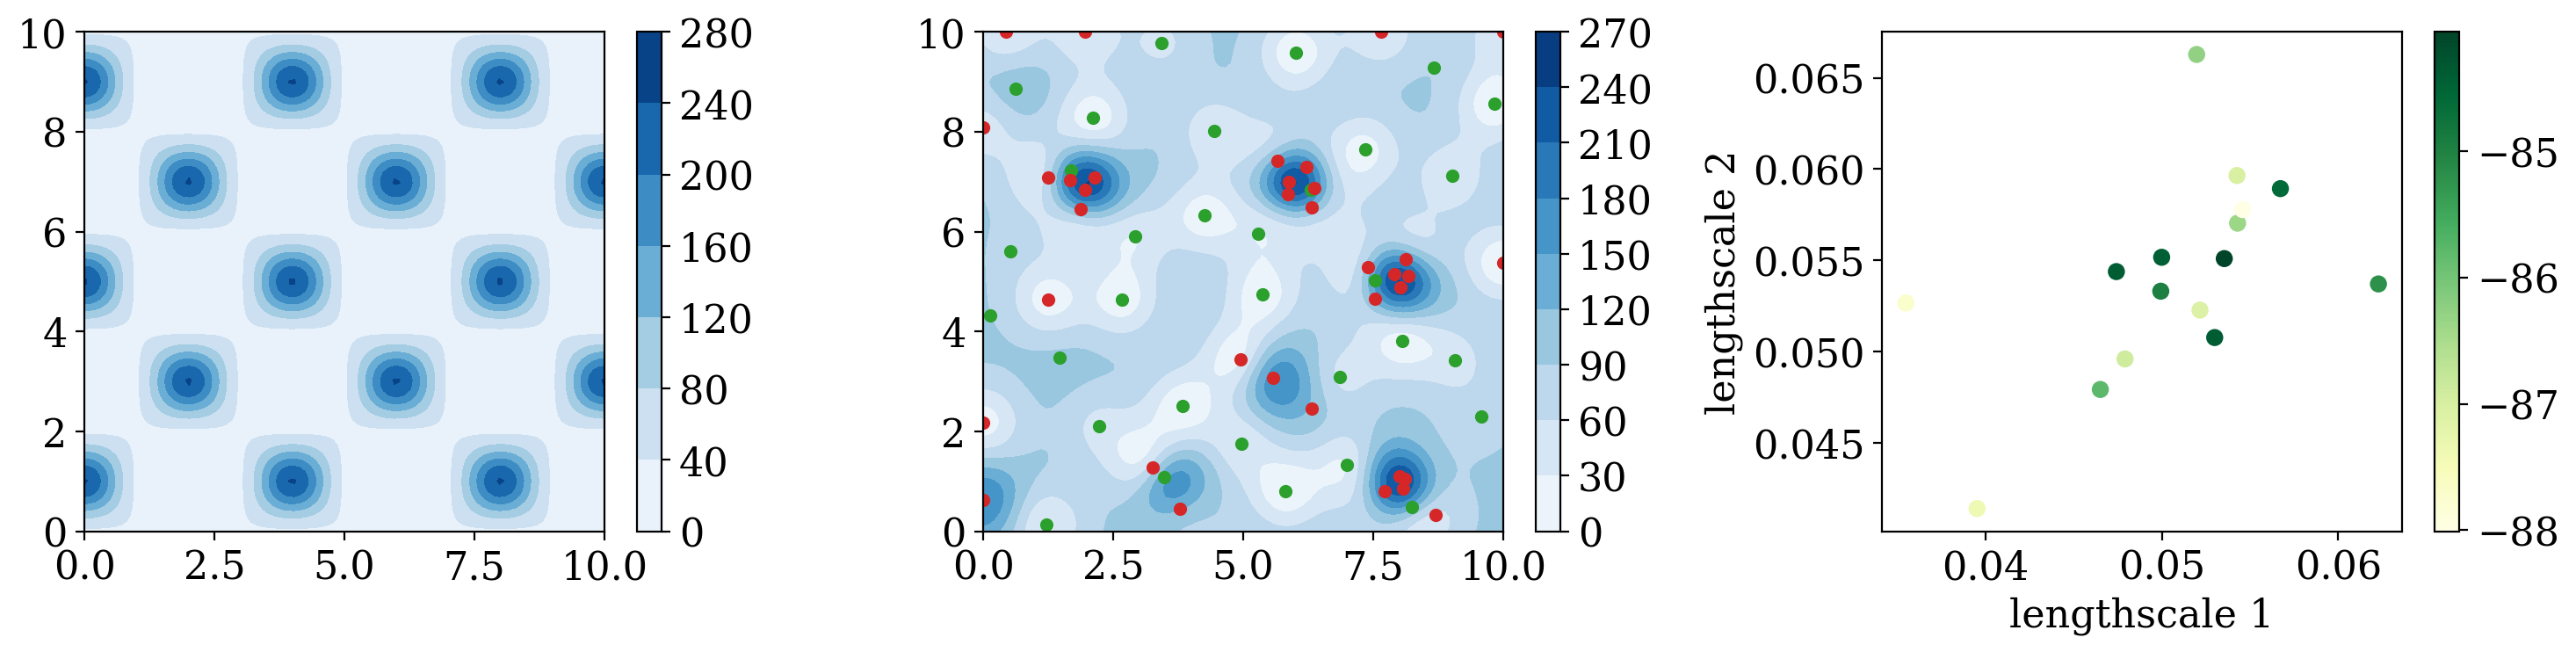

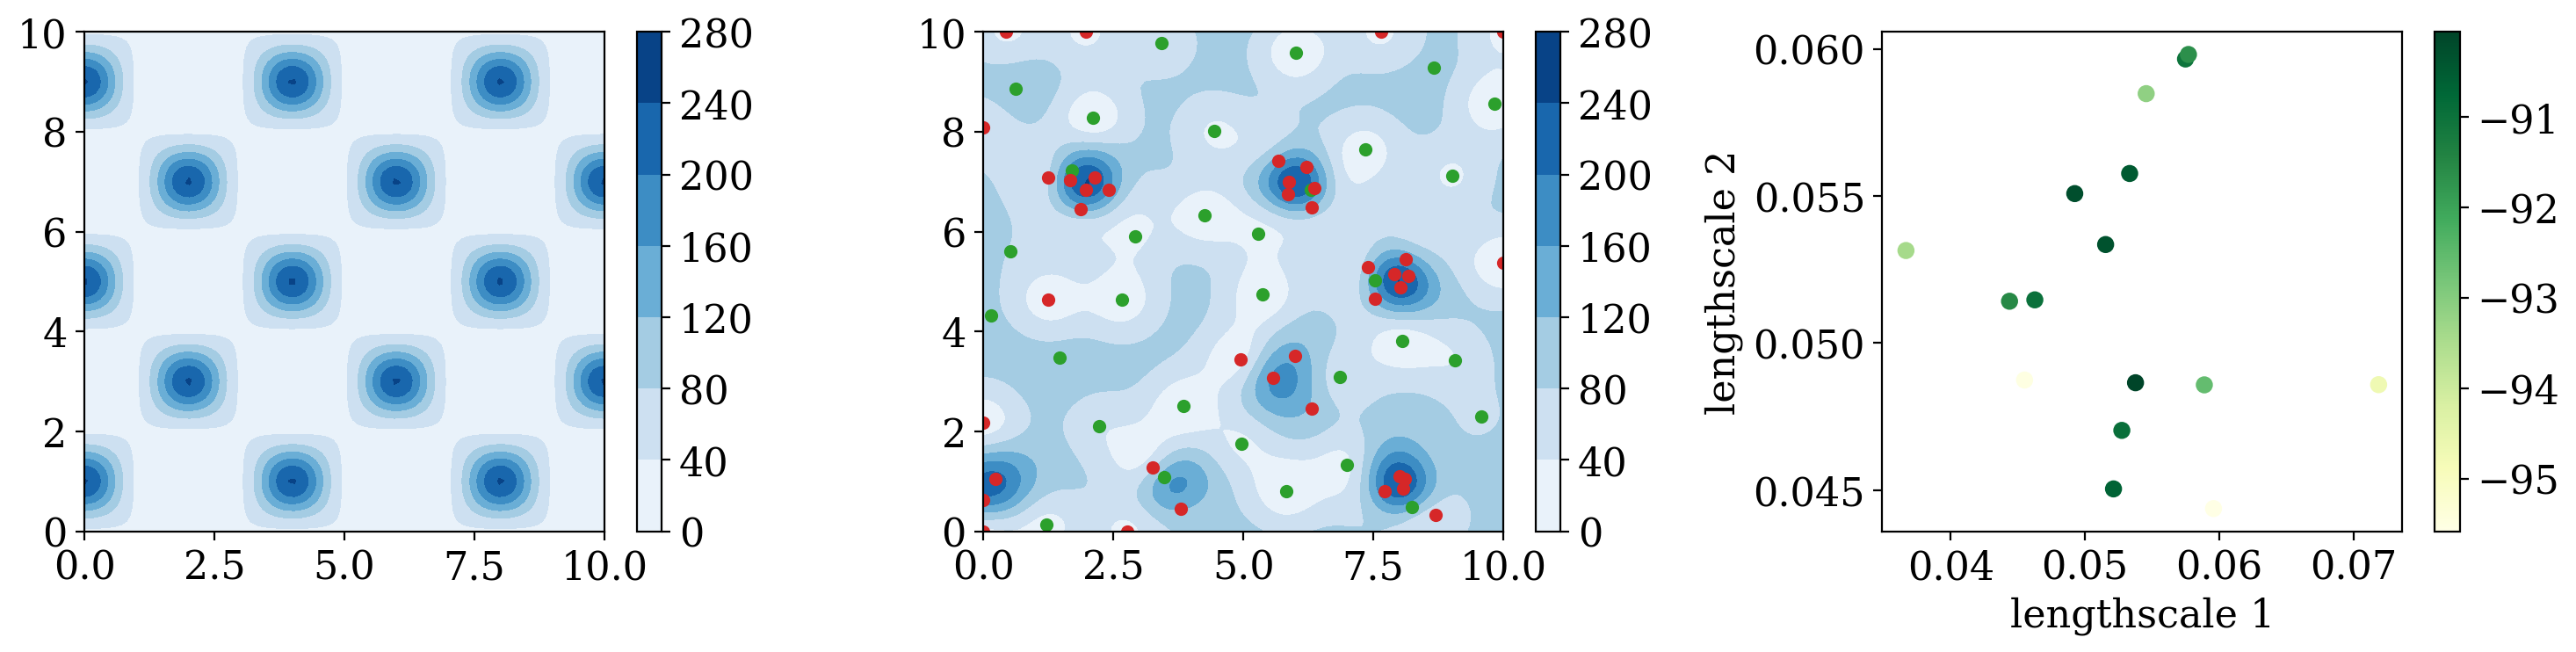

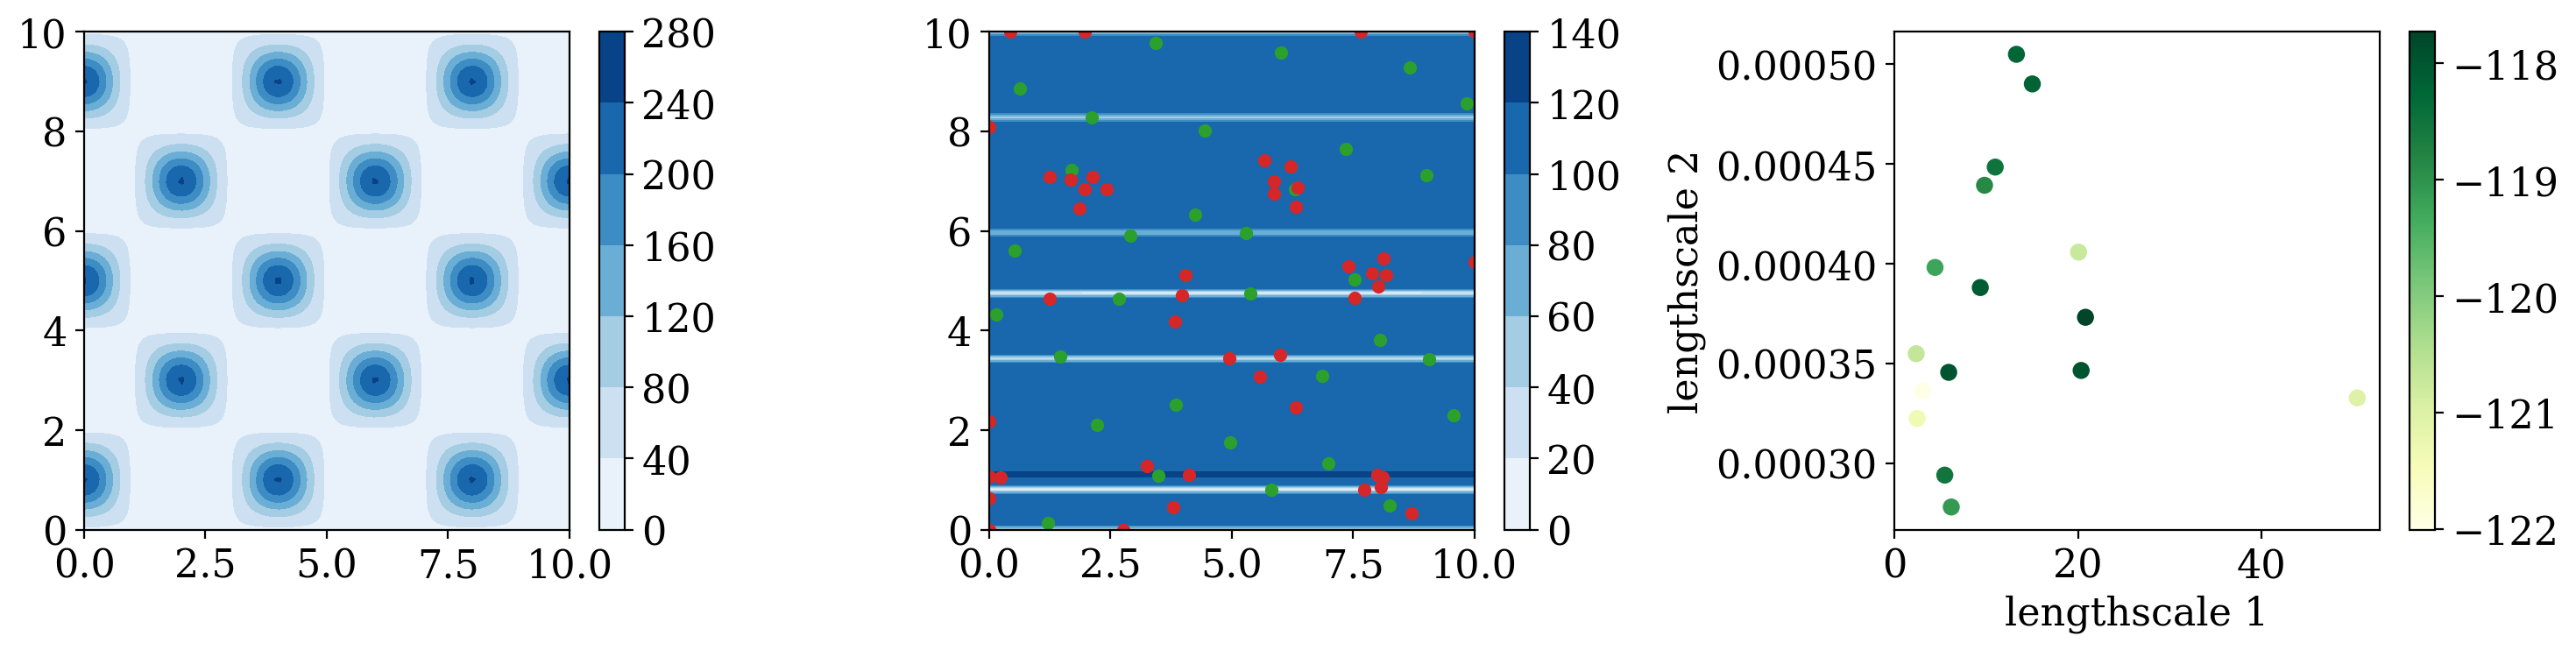

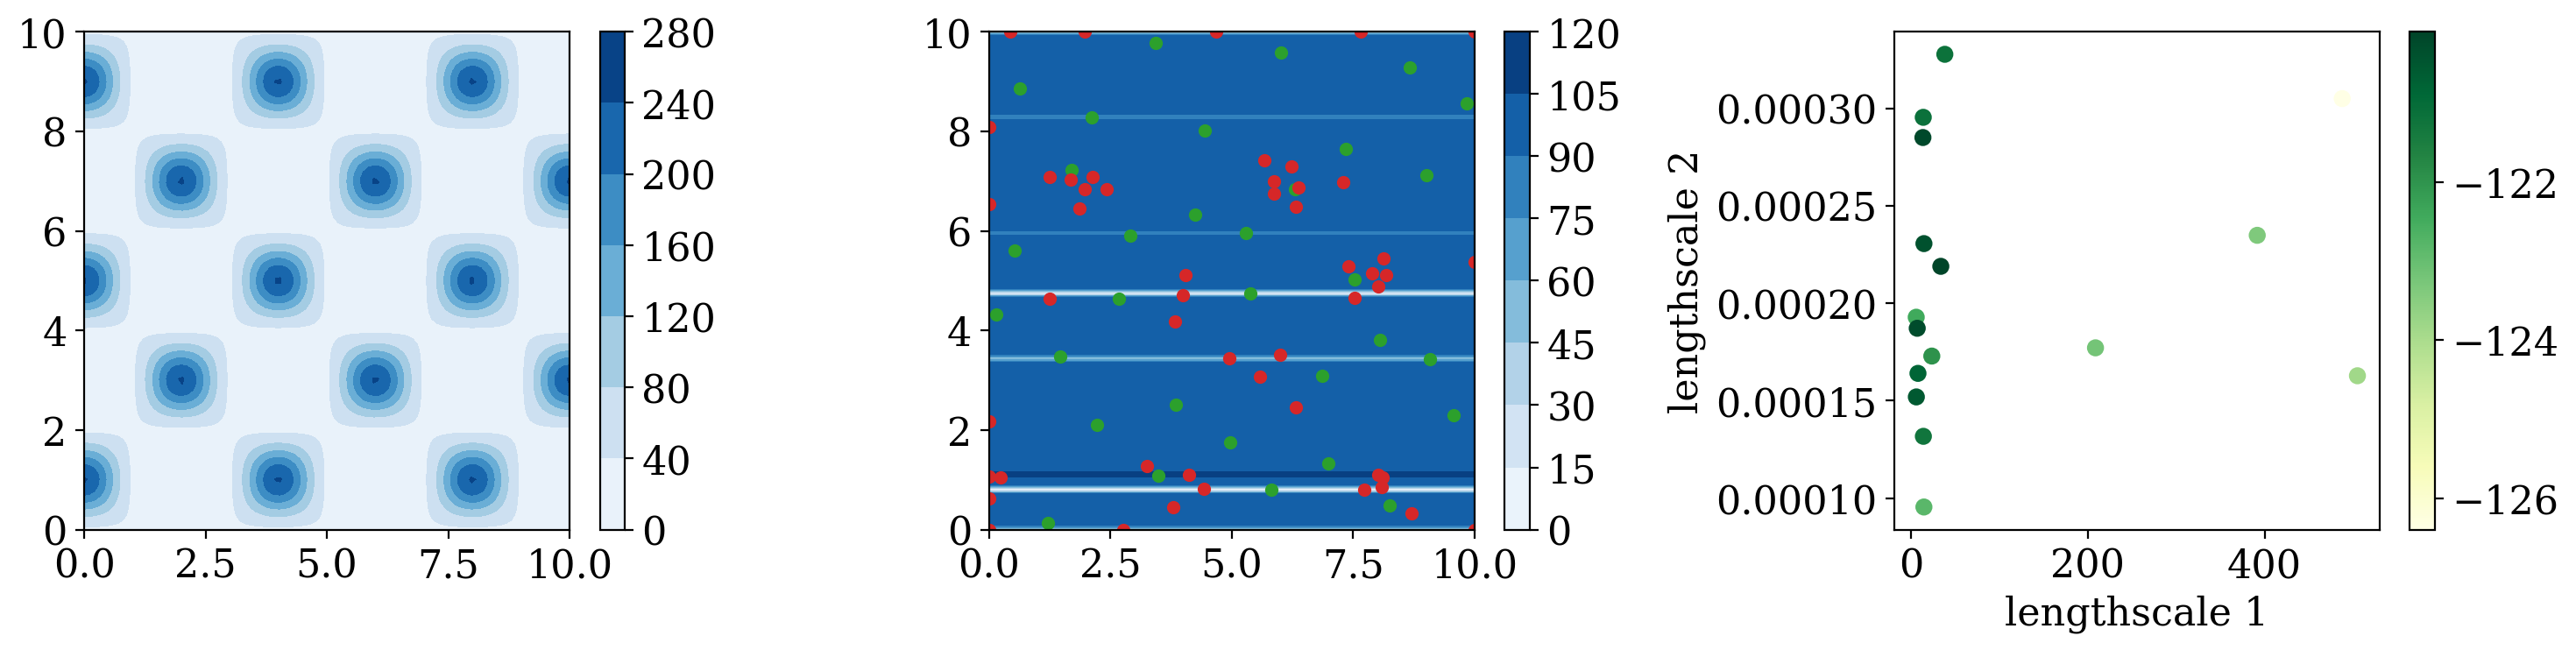

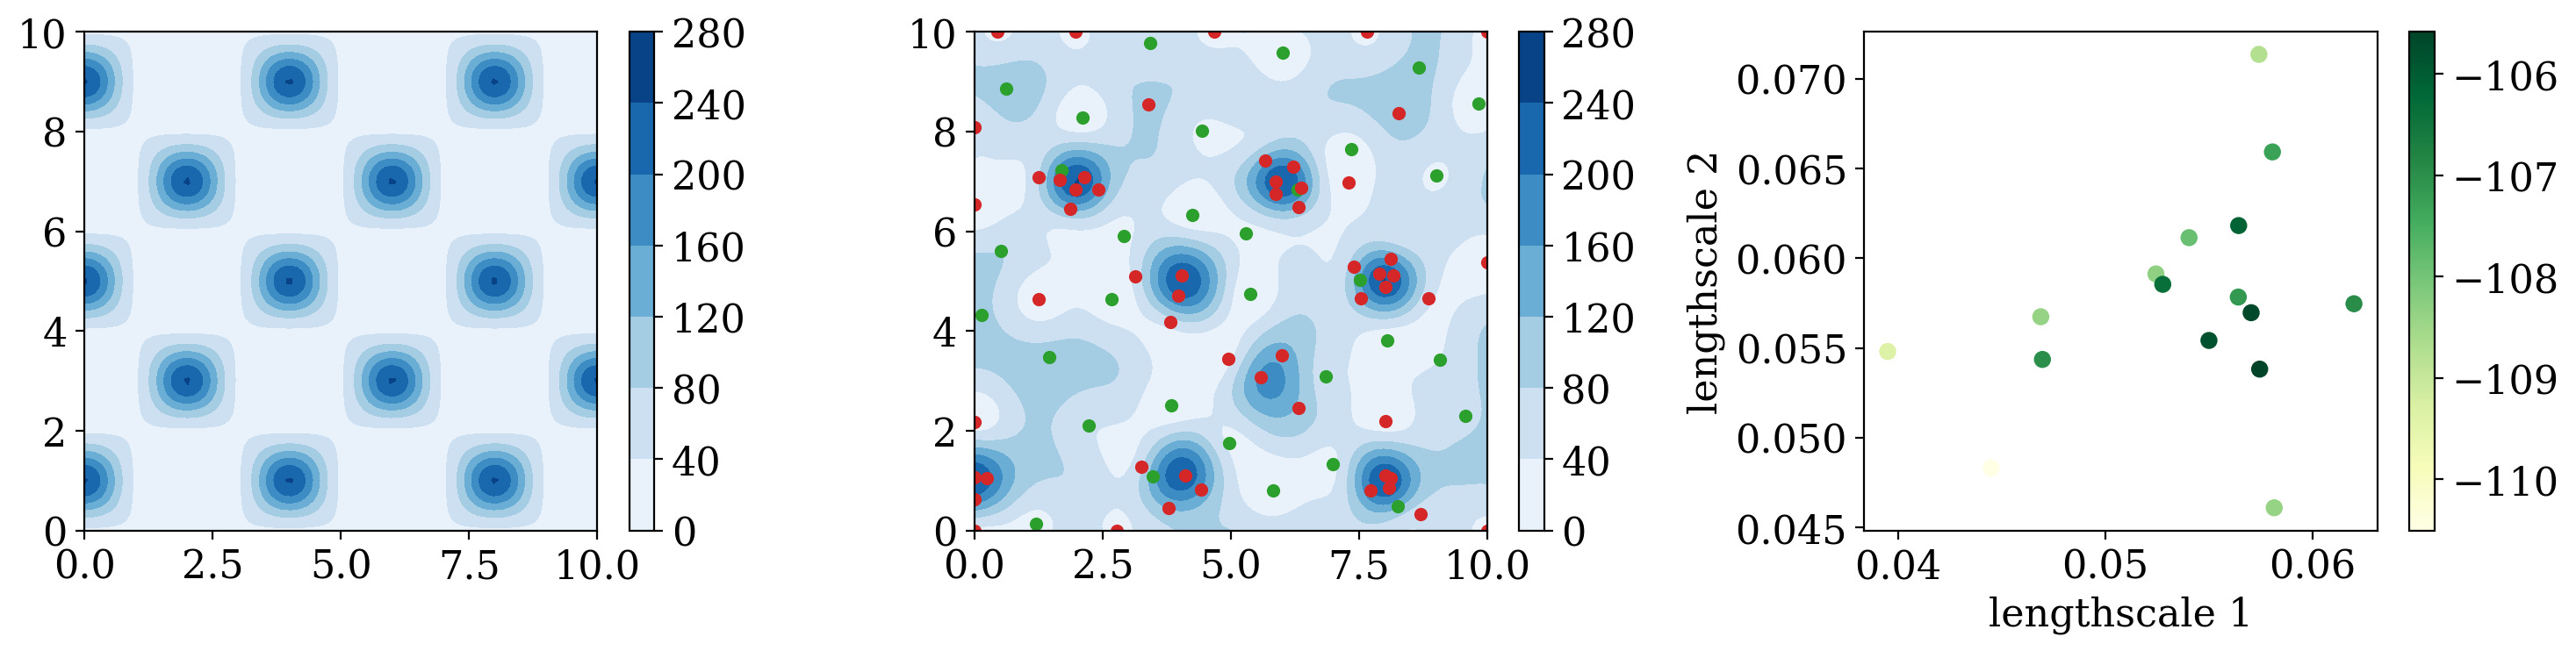

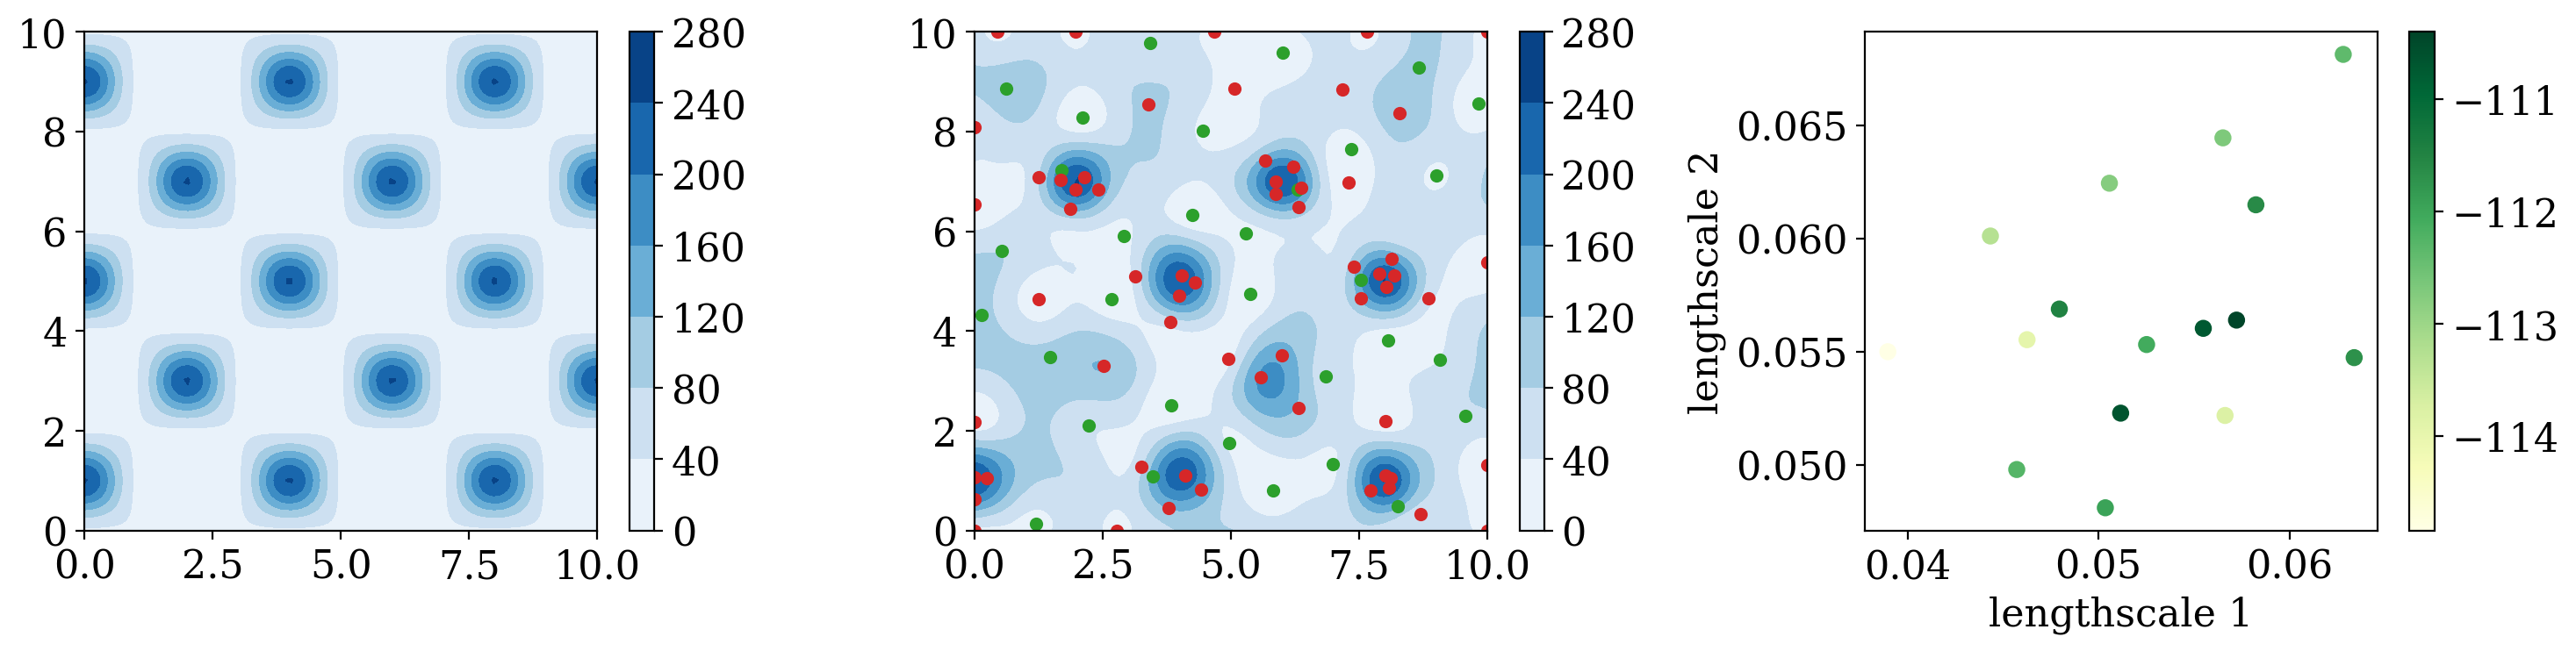

In [37]:
nsteps = 64 # 64
mc_points_size = 16
start = time.time()
# fig, ax = plt.subplots(1,3,figsize=(15,3))
for i in range(nsteps):
    samples_unit, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    size = len(samples_unit)
    mc_points = samples_unit[::int(size/mc_points_size),:]
    acq_func = EI(gp,gp.train_y.max()) # IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    hess = grad(grad_fn)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/5,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)]})
    # next_val = results.fun 
    next_x_unit = jnp.atleast_2d(results.x)
    next_x = input_unstandardize(next_x_unit)
    next_y = loglike(next_x).reshape(-1,1)
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    train_x_unit = input_standardize(train_x)
    gp = saas_fbgp(train_x_unit,train_y,noise=1e-4)
    gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    if (i%5==0):
        print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
        print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))
        plot_gp(gp,fig,ax1,ax2)
        plot_hypers(gp,ax3)
        fig.tight_layout()
        print(f"----------------------Step {i+1} complete----------------------\n")

print(f"BO took {time.time() - start:.2f} s ")

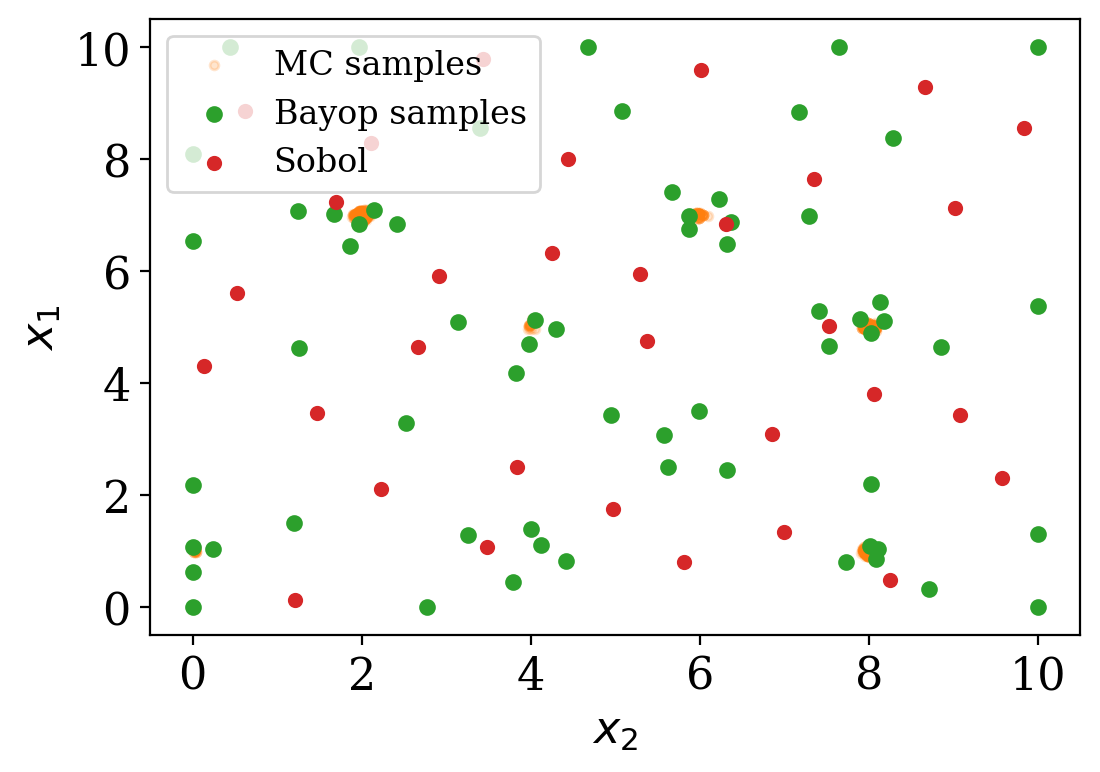

In [39]:
samples = input_unstandardize(samples_unit)

fig,ax = plt.subplots(1,int(ndim/2),figsize=(6,4))
# ax.scatter(samples_unit[:,0],samples_unit[:,0+1],s=10,label='MC samples unit',color='C3',alpha=0.2)
ax.scatter(samples[:,0],samples[:,0+1],s=10,label='MC samples',color='C1',alpha=0.2)
ax.scatter(train_x[ninit:,0],train_x[ninit:,0+1],s=25,label='Bayop samples',color='C2')
ax.scatter(train_x[:ninit,0],train_x[:ninit,0+1],s=20,label='Sobol',color='C3')
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_2$')
    # x.axvline(f_mean[2*i],ls='-.',color='k')
    # x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax.legend(fontsize=12)

In [40]:
samples_unit, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=1000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))
samples = input_unstandardize(samples_unit)

Nested Sampling took 12.04s
jaxns did 774172 likelihood evaluations
LogZ logz_mean: 240.2079, dlogz: 0.2692, 


In [48]:
### Run jaxns directly on loglike

def loglike(theta):
    logpdf = jnp.power(2. + jnp.cos(0.5 *pi* theta[0])*jnp.sin(0.5*pi*theta[1]), 5)
    return logpdf


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.array([0,0]), high = jnp.array([10,10])), name='x')
    return x


model = Model(prior_model=prior_model,log_likelihood=loglike)

model.sanity_check(key=jax.random.PRNGKey(0), S=100)

from jaxns import NestedSampler, TerminationCondition

start = time.time()
ns = NestedSampler(model=model, max_samples=1e5,parameter_estimation=True,difficult_model=True)
term_cond = TerminationCondition(dlogZ=0.01)
# Run the sampler
termination_reason, state = ns(jax.random.PRNGKey(42),term_cond=term_cond)
# Get the results
results = ns.to_results(termination_reason=termination_reason, state=state)
print(f"Nested Sampling took {time.time() - start:.2f}s")
print(f"jaxns did {results.total_num_likelihood_evaluations} likelihood evaluations")
logz_dict = {"logz_mean": results.log_Z_mean, "dlogz": results.log_Z_uncert}
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

samples_jns = resample(key=jax.random.PRNGKey(0),
                    samples=results.samples,
                    log_weights=results.log_dp_mean,
                    S=4000*ndim,
                    replace=True,)
print(samples_jns['x'].shape)

ns.summary(results)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


Nested Sampling took 2.56s
jaxns did 312388 likelihood evaluations
LogZ logz_mean: 236.0875, dlogz: 0.2315, 
(8000, 2)
--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 312388
samples: 6200
phantom samples: 4000
likelihood evals / sample: 50.4
phantom fraction (%): 64.5%
--------
logZ=236.09 +- 0.23
max(logL)=243.0
H=-5.95
ESS=274
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 4.5 +- 3.4 | 0.0 / 4.0 / 10.0 | 8.0 | 8.0
x[1]: 5.0 +- 2.9 | 1.0 / 5.0 / 9.0 | 5.0 | 5.0
--------


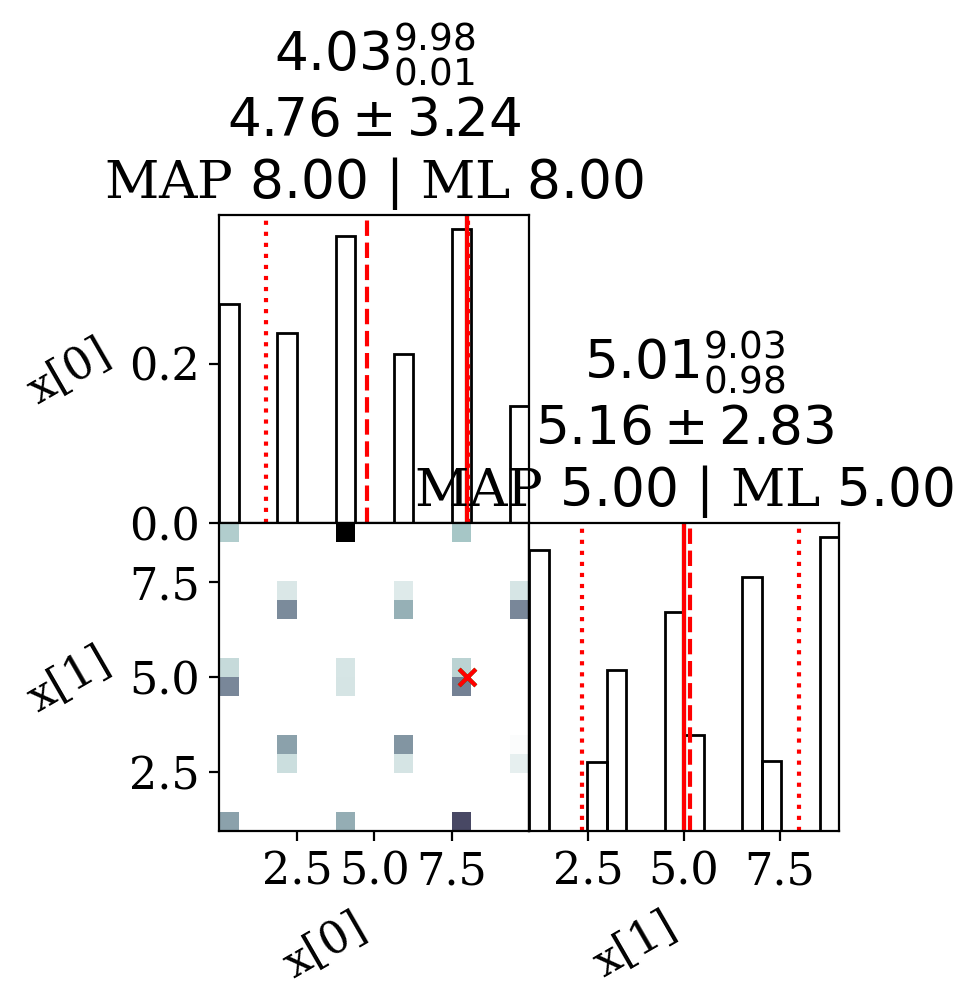

In [49]:
ns.plot_cornerplot(results)

Removed no burn in
Removed no burn in


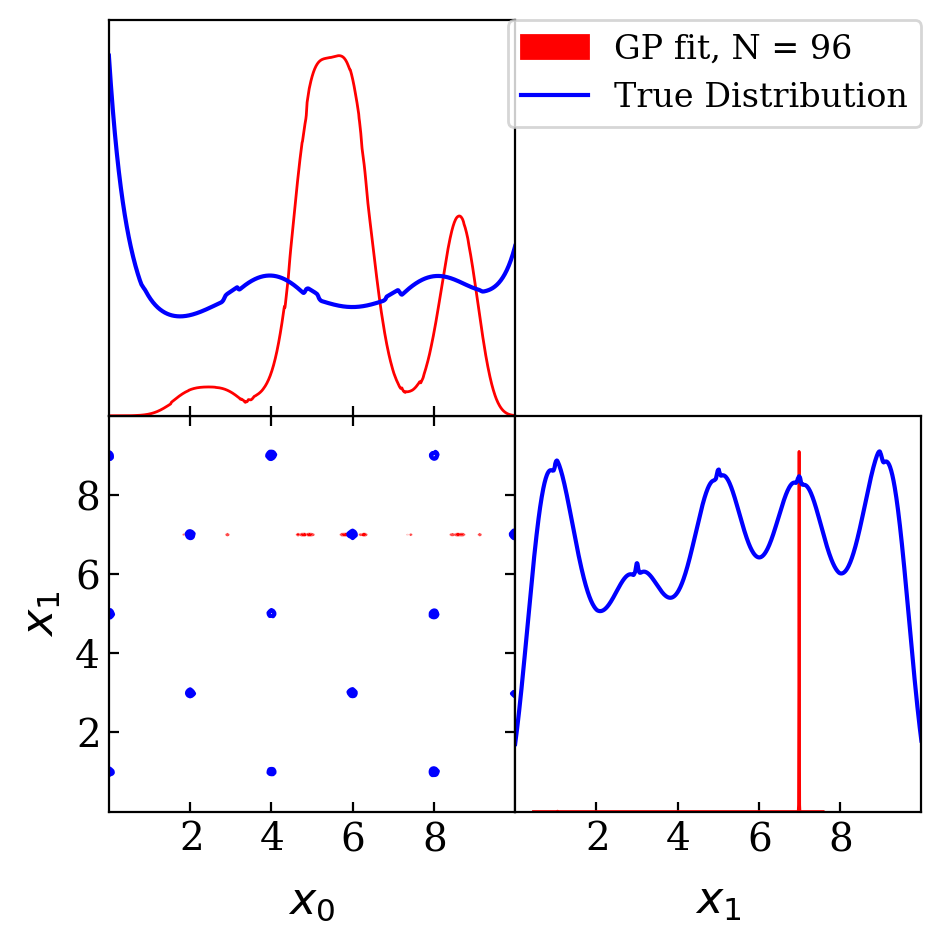

In [47]:
# test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  param_bounds.T
f_mean = np.array([0.2,0.])
jns_samples = MCSamples(samples=samples_jns['x'],names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::2],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,jns_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} ','True Distribution'],
                                contour_lws=[1,1.5]) #,markers = dict(zip(names,f_mean)),
                                #marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

### IPV 

In [70]:
train_x_unit = qmc.Sobol(ndim, scramble=True).random(ninit)

train_x = input_unstandardize(train_x_unit)

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[:,0]))**2 - (20*(X[:,1]/4 - X[:,0]**4))**2
    return logpdf.reshape(-1,1)
train_y = loglike(train_x)
print("Testing lightweight implementation")

gp = saas_fbgp(train_x_unit,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 888.94it/s, 7 steps of size 3.24e-01. acc. prob=0.89]



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     41.89     97.07      8.53      0.14     67.36     41.29      0.97
_kernel_inv_length_sq[1]      5.89     18.29      1.91      0.02      6.79     33.08      1.01
        kernel_length[0]      0.21      0.10      0.20      0.06      0.36     16.13      1.09
        kernel_length[1]      0.54      0.40      0.38      0.06      1.04     58.17      0.97
            kernel_tausq     12.76     25.69      2.80      0.05     27.62     16.22      1.02
              kernel_var      5.76      5.32      4.32      0.90     10.81     38.78      0.97

Number of divergences: 0

MCMC elapsed time: 1.67s


In [71]:
nsteps = 32 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples_unit, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples_unit)
    mc_points = samples_unit[::int(size/mc_points_size),:]
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/5,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x_unit = jnp.atleast_2d(results.x)
    next_x = input_unstandardize(next_x_unit)
    next_y = loglike(next_x)
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    train_x_unit = input_standardize(train_x)
    gp = saas_fbgp(train_x_unit,train_y,noise=1e-4)
    gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

Nested Sampling took 2.07s
jaxns did 13203 likelihood evaluations
LogZ info :logz_mean: = -0.1657, dlogz: = 0.3510, 
Acquisition optimization took 3.07 s
Next point at x = [0.3535952  0.53332941] with acquisition function value = 0.13811313005368592


sample: 100%|██████████| 512/512 [00:01<00:00, 437.29it/s, 11 steps of size 4.58e-01. acc. prob=0.83]



MCMC elapsed time: 1.61s
----------------------Step 1 complete----------------------

Nested Sampling took 2.42s
jaxns did 13475 likelihood evaluations
LogZ info :logz_mean: = -5.1838, dlogz: = 0.3483, 
Acquisition optimization took 3.29 s
Next point at x = [0.5888766  0.24883682] with acquisition function value = 0.052201335768696566


sample: 100%|██████████| 512/512 [00:00<00:00, 531.22it/s, 7 steps of size 3.54e-01. acc. prob=0.85] 



MCMC elapsed time: 1.44s
----------------------Step 2 complete----------------------

Nested Sampling took 1.75s
jaxns did 9033 likelihood evaluations
LogZ info :logz_mean: = 10.4239, dlogz: = 0.3884, 
Acquisition optimization took 2.38 s
Next point at x = [0.96566589 0.98344539] with acquisition function value = 0.022928450745959103


sample: 100%|██████████| 512/512 [00:00<00:00, 569.00it/s, 7 steps of size 3.05e-01. acc. prob=0.87] 



MCMC elapsed time: 1.22s
----------------------Step 3 complete----------------------

Nested Sampling took 1.74s
jaxns did 10939 likelihood evaluations
LogZ info :logz_mean: = 11.5837, dlogz: = 0.3734, 
Acquisition optimization took 2.33 s
Next point at x = [0.2679444  0.04519572] with acquisition function value = 0.017500074178138817


sample: 100%|██████████| 512/512 [00:00<00:00, 612.54it/s, 7 steps of size 3.12e-01. acc. prob=0.83] 



MCMC elapsed time: 1.17s
----------------------Step 4 complete----------------------

Nested Sampling took 1.78s
jaxns did 16347 likelihood evaluations
LogZ info :logz_mean: = -2.9518, dlogz: = 0.3775, 
Acquisition optimization took 2.71 s
Next point at x = [0.56956127 0.30990005] with acquisition function value = 0.014332756456741327


sample: 100%|██████████| 512/512 [00:00<00:00, 587.37it/s, 7 steps of size 4.23e-01. acc. prob=0.74]



MCMC elapsed time: 1.20s
----------------------Step 5 complete----------------------

Nested Sampling took 3.56s
jaxns did 12545 likelihood evaluations
LogZ info :logz_mean: = -4.8023, dlogz: = 0.3446, 
Acquisition optimization took 2.45 s
Next point at x = [0.8353553  0.84642789] with acquisition function value = 0.0005567029705841999


sample: 100%|██████████| 512/512 [00:00<00:00, 534.66it/s, 7 steps of size 4.50e-01. acc. prob=0.83] 



MCMC elapsed time: 1.29s
----------------------Step 6 complete----------------------

Nested Sampling took 1.78s
jaxns did 12316 likelihood evaluations
LogZ info :logz_mean: = 2.5048, dlogz: = 0.3607, 
Acquisition optimization took 2.45 s
Next point at x = [0.92218791 0.71719911] with acquisition function value = 0.0035532038995116783


sample: 100%|██████████| 512/512 [00:00<00:00, 590.14it/s, 15 steps of size 2.38e-01. acc. prob=0.86]



MCMC elapsed time: 1.24s
----------------------Step 7 complete----------------------

Nested Sampling took 1.82s
jaxns did 17435 likelihood evaluations
LogZ info :logz_mean: = 7.2458, dlogz: = 0.3649, 
Acquisition optimization took 2.26 s
Next point at x = [0.20153806 0.69038886] with acquisition function value = 0.05723076813920433


sample: 100%|██████████| 512/512 [00:00<00:00, 658.39it/s, 7 steps of size 5.52e-01. acc. prob=0.90] 



MCMC elapsed time: 1.08s
----------------------Step 8 complete----------------------

Nested Sampling took 1.91s
jaxns did 10872 likelihood evaluations
LogZ info :logz_mean: = 1.3035, dlogz: = 0.3266, 
Acquisition optimization took 2.38 s
Next point at x = [0.46218634 0.54221415] with acquisition function value = 0.011488984470599855


sample: 100%|██████████| 512/512 [00:00<00:00, 641.65it/s, 7 steps of size 6.52e-01. acc. prob=0.83] 



MCMC elapsed time: 1.10s
----------------------Step 9 complete----------------------

Nested Sampling took 1.91s
jaxns did 11257 likelihood evaluations
LogZ info :logz_mean: = -2.8343, dlogz: = 0.3427, 
Acquisition optimization took 2.36 s
Next point at x = [0.88847687 0.96494103] with acquisition function value = 0.01018315855807356


sample: 100%|██████████| 512/512 [00:00<00:00, 541.61it/s, 15 steps of size 3.26e-01. acc. prob=0.95]



MCMC elapsed time: 1.31s
----------------------Step 10 complete----------------------

Nested Sampling took 1.98s
jaxns did 10728 likelihood evaluations
LogZ info :logz_mean: = -2.9939, dlogz: = 0.3275, 
Acquisition optimization took 2.47 s
Next point at x = [0.34788487 0.36238655] with acquisition function value = 0.003190535448173772


sample: 100%|██████████| 512/512 [00:00<00:00, 560.58it/s, 7 steps of size 5.63e-01. acc. prob=0.90]



MCMC elapsed time: 1.28s
----------------------Step 11 complete----------------------

Nested Sampling took 1.90s
jaxns did 12462 likelihood evaluations
LogZ info :logz_mean: = -3.8418, dlogz: = 0.3460, 
Acquisition optimization took 2.87 s
Next point at x = [0.51579424 0.51370789] with acquisition function value = 0.0015214053628422024


sample: 100%|██████████| 512/512 [00:00<00:00, 602.27it/s, 7 steps of size 6.17e-01. acc. prob=0.91]



MCMC elapsed time: 1.23s
----------------------Step 12 complete----------------------

Nested Sampling took 2.03s
jaxns did 11669 likelihood evaluations
LogZ info :logz_mean: = -4.2945, dlogz: = 0.3303, 
Acquisition optimization took 3.01 s
Next point at x = [0.39032557 0.31658564] with acquisition function value = 0.00028361366527693624


sample: 100%|██████████| 512/512 [00:00<00:00, 629.01it/s, 7 steps of size 7.78e-01. acc. prob=0.88]



MCMC elapsed time: 1.14s
----------------------Step 13 complete----------------------

Nested Sampling took 1.90s
jaxns did 12067 likelihood evaluations
LogZ info :logz_mean: = -4.1759, dlogz: = 0.3276, 
Acquisition optimization took 2.47 s
Next point at x = [0.45884446 0.37364385] with acquisition function value = 0.00013502174184279632


sample: 100%|██████████| 512/512 [00:00<00:00, 606.69it/s, 7 steps of size 8.43e-01. acc. prob=0.87]



MCMC elapsed time: 1.20s
----------------------Step 14 complete----------------------

Nested Sampling took 1.99s
jaxns did 9360 likelihood evaluations
LogZ info :logz_mean: = -3.7420, dlogz: = 0.3066, 
Acquisition optimization took 1.50 s
Next point at x = [0.3145744 0.7292065] with acquisition function value = 0.00012546603597394373


sample: 100%|██████████| 512/512 [00:00<00:00, 576.33it/s, 7 steps of size 6.40e-01. acc. prob=0.90]



MCMC elapsed time: 1.25s
----------------------Step 15 complete----------------------

Nested Sampling took 2.01s
jaxns did 8596 likelihood evaluations
LogZ info :logz_mean: = -3.7113, dlogz: = 0.3036, 
Acquisition optimization took 1.45 s
Next point at x = [0.29067117 0.45780714] with acquisition function value = 0.0003299772880361908


sample: 100%|██████████| 512/512 [00:00<00:00, 589.70it/s, 7 steps of size 7.14e-01. acc. prob=0.89]



MCMC elapsed time: 1.27s
----------------------Step 16 complete----------------------

Nested Sampling took 2.00s
jaxns did 10025 likelihood evaluations
LogZ info :logz_mean: = -3.8783, dlogz: = 0.3091, 
Acquisition optimization took 2.52 s
Next point at x = [0.64748612 0.37218585] with acquisition function value = 0.00013379411847474001


sample: 100%|██████████| 512/512 [00:00<00:00, 608.60it/s, 7 steps of size 6.36e-01. acc. prob=0.93]



MCMC elapsed time: 1.13s
----------------------Step 17 complete----------------------

Nested Sampling took 4.93s
jaxns did 8967 likelihood evaluations
LogZ info :logz_mean: = -3.4653, dlogz: = 0.2955, 
Acquisition optimization took 3.11 s
Next point at x = [0.66984791 0.51259264] with acquisition function value = 8.803014141926455e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 452.47it/s, 7 steps of size 8.10e-01. acc. prob=0.90] 



MCMC elapsed time: 1.57s
----------------------Step 18 complete----------------------

Nested Sampling took 2.16s
jaxns did 9115 likelihood evaluations
LogZ info :logz_mean: = -3.4804, dlogz: = 0.2945, 
Acquisition optimization took 2.61 s
Next point at x = [0.38664025 0.17074086] with acquisition function value = 9.838637938112613e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 580.03it/s, 3 steps of size 9.03e-01. acc. prob=0.88] 



MCMC elapsed time: 1.28s
----------------------Step 19 complete----------------------

Nested Sampling took 2.29s
jaxns did 8967 likelihood evaluations
LogZ info :logz_mean: = -3.3745, dlogz: = 0.2923, 
Acquisition optimization took 2.75 s
Next point at x = [0.68939115 0.30954437] with acquisition function value = 9.421998965501374e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 565.33it/s, 7 steps of size 8.20e-01. acc. prob=0.88]



MCMC elapsed time: 1.30s
----------------------Step 20 complete----------------------

Nested Sampling took 2.18s
jaxns did 10376 likelihood evaluations
LogZ info :logz_mean: = -3.1780, dlogz: = 0.2919, 
Acquisition optimization took 1.73 s
Next point at x = [0.49628878 0.26431844] with acquisition function value = 7.182451402096279e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 554.33it/s, 7 steps of size 7.77e-01. acc. prob=0.90]



MCMC elapsed time: 1.30s
----------------------Step 21 complete----------------------

Nested Sampling took 2.21s
jaxns did 9800 likelihood evaluations
LogZ info :logz_mean: = -3.1999, dlogz: = 0.2909, 
Acquisition optimization took 2.22 s
Next point at x = [0.73367815 0.36640764] with acquisition function value = 7.348799813703538e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 522.99it/s, 3 steps of size 7.99e-01. acc. prob=0.91]



MCMC elapsed time: 1.34s
----------------------Step 22 complete----------------------

Nested Sampling took 2.26s
jaxns did 8528 likelihood evaluations
LogZ info :logz_mean: = -3.1168, dlogz: = 0.2896, 
Acquisition optimization took 1.48 s
Next point at x = [0.52403986 0.        ] with acquisition function value = 6.600993013070738e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 554.24it/s, 3 steps of size 7.89e-01. acc. prob=0.91]



MCMC elapsed time: 1.35s
----------------------Step 23 complete----------------------

Nested Sampling took 2.26s
jaxns did 8273 likelihood evaluations
LogZ info :logz_mean: = -3.1200, dlogz: = 0.2870, 
Acquisition optimization took 1.10 s
Next point at x = [0.77508915 0.48493377] with acquisition function value = 5.413063774095672e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 303.68it/s, 7 steps of size 7.35e-01. acc. prob=0.90] 



MCMC elapsed time: 2.28s
----------------------Step 24 complete----------------------

Nested Sampling took 1.89s
jaxns did 8713 likelihood evaluations
LogZ info :logz_mean: = -3.0383, dlogz: = 0.2865, 
Acquisition optimization took 1.31 s
Next point at x = [0.81583    0.38240894] with acquisition function value = 5.61249730759647e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 289.24it/s, 7 steps of size 7.89e-01. acc. prob=0.90] 



MCMC elapsed time: 2.22s
----------------------Step 25 complete----------------------

Nested Sampling took 1.89s
jaxns did 8297 likelihood evaluations
LogZ info :logz_mean: = -2.9669, dlogz: = 0.2822, 
Acquisition optimization took 1.24 s
Next point at x = [0.86138731 0.56102258] with acquisition function value = 5.2747512312482925e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 281.80it/s, 7 steps of size 7.30e-01. acc. prob=0.89] 



MCMC elapsed time: 2.31s
----------------------Step 26 complete----------------------

Nested Sampling took 1.87s
jaxns did 8465 likelihood evaluations
LogZ info :logz_mean: = -2.9887, dlogz: = 0.2822, 
Acquisition optimization took 1.01 s
Next point at x = [0.82357265 0.58904105] with acquisition function value = 8.332493947260655e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 293.72it/s, 3 steps of size 7.80e-01. acc. prob=0.91] 



MCMC elapsed time: 2.25s
----------------------Step 27 complete----------------------

Nested Sampling took 1.79s
jaxns did 8376 likelihood evaluations
LogZ info :logz_mean: = -2.9454, dlogz: = 0.2789, 
Acquisition optimization took 0.87 s
Next point at x = [0.50229887 0.99260944] with acquisition function value = 4.541315067259355e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 303.32it/s, 3 steps of size 9.04e-01. acc. prob=0.86] 



MCMC elapsed time: 2.16s
----------------------Step 28 complete----------------------

Nested Sampling took 1.91s
jaxns did 7978 likelihood evaluations
LogZ info :logz_mean: = -3.1990, dlogz: = 0.2936, 
Acquisition optimization took 0.90 s
Next point at x = [0.68160915 0.74265464] with acquisition function value = 6.329531873447425e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 280.78it/s, 3 steps of size 6.93e-01. acc. prob=0.91] 



MCMC elapsed time: 2.31s
----------------------Step 29 complete----------------------

Nested Sampling took 1.83s
jaxns did 7810 likelihood evaluations
LogZ info :logz_mean: = -3.0959, dlogz: = 0.2895, 
Acquisition optimization took 0.85 s
Next point at x = [0.54718453 0.58499607] with acquisition function value = 4.108483713367167e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 254.18it/s, 7 steps of size 7.51e-01. acc. prob=0.91] 



MCMC elapsed time: 2.53s
----------------------Step 30 complete----------------------

Nested Sampling took 2.00s
jaxns did 7845 likelihood evaluations
LogZ info :logz_mean: = -3.1299, dlogz: = 0.2923, 
Acquisition optimization took 0.95 s
Next point at x = [0.92819963 0.37163491] with acquisition function value = 4.509966204586241e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 110.00it/s, 7 steps of size 6.48e-01. acc. prob=0.93] 



MCMC elapsed time: 5.22s
----------------------Step 31 complete----------------------

Nested Sampling took 2.02s
jaxns did 8042 likelihood evaluations
LogZ info :logz_mean: = -3.0373, dlogz: = 0.2766, 
Acquisition optimization took 0.78 s
Next point at x = [0.51528625 0.69901999] with acquisition function value = 4.241475013888607e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 258.09it/s, 7 steps of size 6.41e-01. acc. prob=0.93] 



MCMC elapsed time: 2.49s
----------------------Step 32 complete----------------------

BO took 187.67 s 


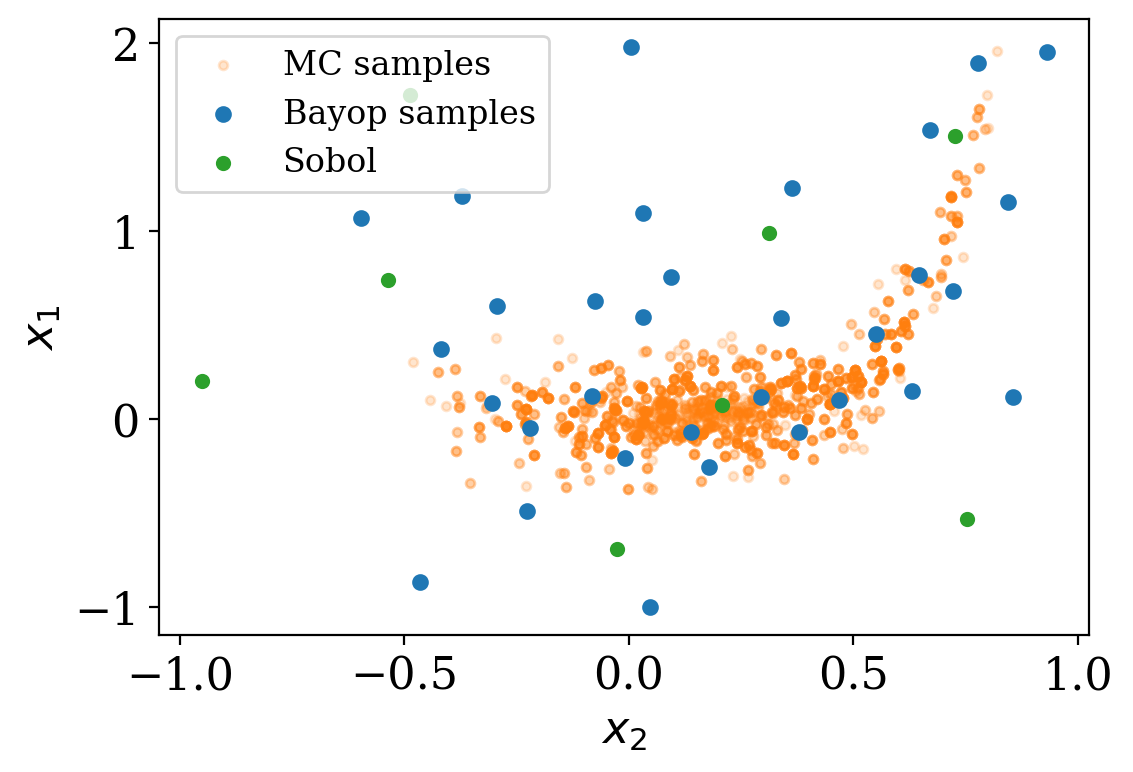

In [72]:
samples = input_unstandardize(samples_unit)

fig,ax = plt.subplots(1,int(ndim/2),figsize=(6,4))
# ax.scatter(samples_unit[:,0],samples_unit[:,0+1],s=10,label='MC samples unit',color='C3',alpha=0.2)
ax.scatter(samples[:,0],samples[:,0+1],s=10,label='MC samples',color='C1',alpha=0.2)
ax.scatter(train_x[ninit:,0],train_x[ninit:,0+1],s=25,label='Bayop samples',color='C0')
ax.scatter(train_x[:ninit,0],train_x[:ninit,0+1],s=20,label='Sobol',color='C2')
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_2$')
    # x.axvline(f_mean[2*i],ls='-.',color='k')
    # x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax.legend(fontsize=12)

In [73]:
samples_unit, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=1000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))
samples = input_unstandardize(samples_unit)

Nested Sampling took 3.28s
jaxns did 152608 likelihood evaluations
LogZ logz_mean: -3.0294, dlogz: 0.1641, 


In [74]:
### Run jaxns directly on loglike

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[0]))**2 - (20*(X[1]/4 - X[0]**4))**2
    return logpdf


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.array([-1,-1]), high= jnp.array([1,2])), name='x')
    return x


model = Model(prior_model=prior_model,log_likelihood=loglike)

model.sanity_check(key=jax.random.PRNGKey(0), S=100)

from jaxns import NestedSampler, TerminationCondition

start = time.time()
ns = NestedSampler(model=model, max_samples=1e5,parameter_estimation=True,difficult_model=True)
term_cond = TerminationCondition(dlogZ=0.01)
# Run the sampler
termination_reason, state = ns(jax.random.PRNGKey(42),term_cond=term_cond)
# Get the results
results = ns.to_results(termination_reason=termination_reason, state=state)
print(f"Nested Sampling took {time.time() - start:.2f}s")
print(f"jaxns did {results.total_num_likelihood_evaluations} likelihood evaluations")
logz_dict = {"logz_mean": results.log_Z_mean, "dlogz": results.log_Z_uncert}
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

samples_jns = resample(key=jax.random.PRNGKey(0),
                    samples=results.samples,
                    log_weights=results.log_dp_mean,
                    S=4000*ndim,
                    replace=True,)
print(samples_jns['x'].shape)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


Nested Sampling took 1.90s
jaxns did 150677 likelihood evaluations
LogZ logz_mean: -3.0650, dlogz: 0.1648, 
(8000, 2)


Removed no burn in
Removed no burn in


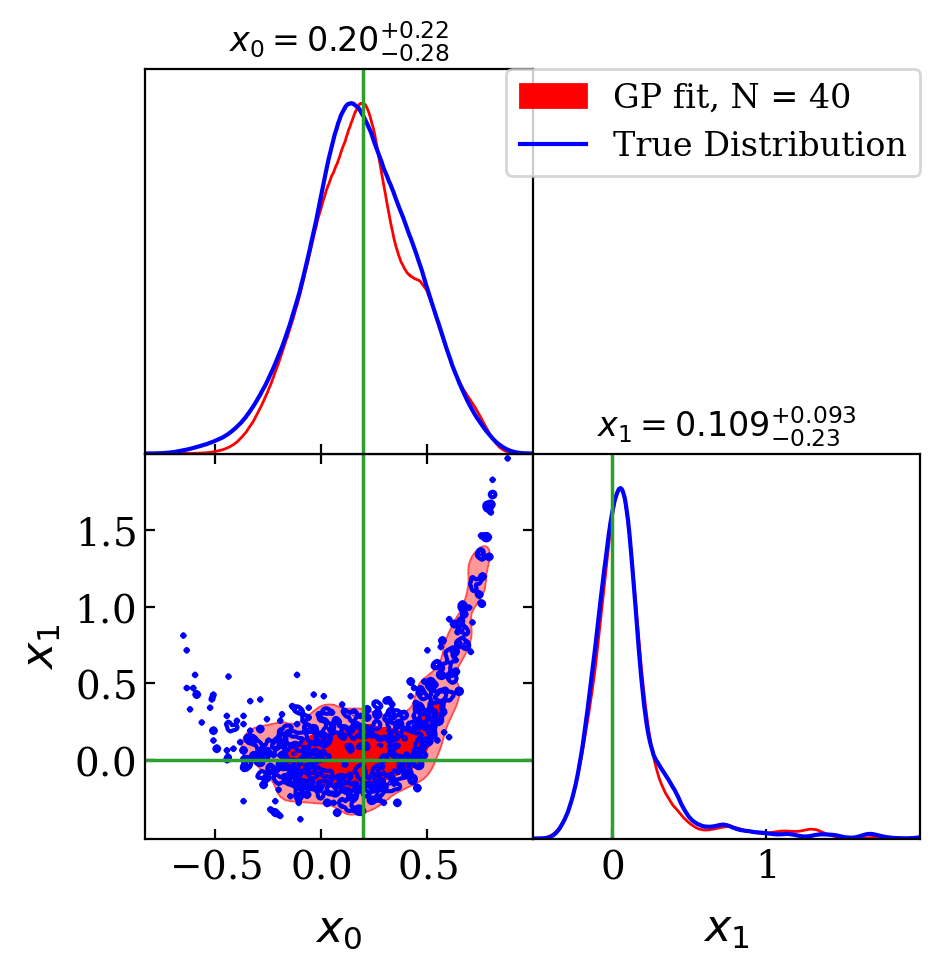

In [75]:
# test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  param_bounds.T
f_mean = np.array([0.2,0.])
jns_samples = MCSamples(samples=samples_jns['x'][::4],names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::2],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,jns_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} ','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-',lw=1.25)